# 📊 Projet MLOps - Prédiction du Risque de Défaut sur les Prêts Personnels

## 💼 Contexte
Le secteur de la banque de détail connaît actuellement des taux de défaut plus élevés que prévu sur les prêts personnels. Les prêts personnels sont une source majeure de revenus, mais ils comportent des risques. L'objectif de ce projet est de développer un algorithme capable de prédire le risque de défaut d'un emprunteur.

## 🎯 Objectif
Construire un modèle de machine learning pour prédire si un client fera défaut sur son prêt, en s'appuyant sur les données historiques fournies par la banque.

## 🧩 Approche MLOps End-to-End
Ce notebook suit une approche MLOps complète, en passant par les étapes suivantes :
1. Compréhension du problème
2. Préparation et analyse des données
3. Modélisation avec plusieurs algorithmes
4. Évaluation des performances
5. Sauvegarde du modèle pour un futur déploiement

---

## 🔍 Jeu de données
Nom du fichier : `Loan_Data.csv`

Ce fichier contient des informations sur les prêts octroyés, les caractéristiques des emprunteurs, et s'ils ont fait défaut ou non.


# Modèle de prédiction de défaut de prêts

Ce notebook a pour objectif de construire un modèle de **prédiction de défaut** 
sur un portefeuille de prêts, en utilisant le fichier `Loan_Data.csv`.

Nous allons suivre une démarche étape par étape :
1. Compréhension du jeu de données
2. Pré-traitement et préparation des variables
3. Entraînement de plusieurs modèles de classification
4. Évaluation et calibration
5. Sauvegarde du meilleur modèle pour un futur déploiement (Streamlit / Flask)

---


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Librairies de machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)
import mlflow
import mlflow.sklearn


In [ ]:
# # Nouveau dossier local de tracking (laisse l'ancien mlruns_old tranquille)
# mlflow.set_tracking_uri("file:./mlruns_pd")  # A supprimer 

## 2-  Exploration des données (EDA)

Dans cette section, nous allons explorer le fichier `Loan_Data.csv` afin de :
- Vérifier la structure et les colonnes disponibles
- Contrôler les types de variables et valeurs manquantes
- Examiner la distribution de la variable cible `default`
- Obtenir des statistiques descriptives des variables numériques


### 2.1 Chargement et aperçu du jeu de données

In [11]:
# Chargement des données 

# Définition du chemin d'accès au fichier de données
DATA_PATH = "Data/Loan_Data.csv"

# Chargement des données à partir du fichier CSV 
df = pd.read_csv(DATA_PATH)

# # Affichage des 5 premières lignes du DataFrame pour avoir un aperçu des données
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


### 2.2 Informations générales sur le dataset

Dans cette partie, nous allons examiner :

- Les **dimensions** du dataset (nombre de lignes et de colonnes)  
- La **liste des colonnes** disponibles  
- Les **types de données** (int, float, object, etc.)  
- Un **résumé global** des variables (`df.info()`)  
- Le **nombre de valeurs manquantes** par colonne  
- La **distribution de la variable cible** `default`


In [12]:
# Affichage des noms de toutes les colonnes présentes dans le DataFrame
print("Nom des colonnes disponibles:", df.columns.tolist())

# Dimensions (nb de lignes et nb de colonnes)
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")

# Affichage du type de données (int, float, object, etc.) pour chaque colonne
print("\nTypes de données :")
print(df.dtypes)

# Affichage d’un résumé des informations du DataFrame :
# nombre total de lignes, de colonnes, types de données, non-null counts, etc.
print("\nInformations générales sur les variables :")
print(df.info())

# Affichage du nombre de valeurs manquantes par colonne
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())  

# Affichage de la distribution de la variable cible "default"
# La distribution est normalisée (en pourcentage)
print("\nDistribution de la variable cible 'default' :")
print(df["default"].value_counts(normalize=True))

Nom des colonnes disponibles: ['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']
Nombre de lignes : 10000
Nombre de colonnes : 8

Types de données :
customer_id                   int64
credit_lines_outstanding      int64
loan_amt_outstanding        float64
total_debt_outstanding      float64
income                      float64
years_employed                int64
fico_score                    int64
default                       int64
dtype: object

Informations générales sur les variables :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding

### 2.2 bis Nettoyage des colonnes non pertinentes
Nous retirons la colonne `customer_id`, qui est un identifiant non prédictif.  
Nous créons un nouveau DataFrame `df_model` identique à `df` mais sans cette colonne.  
Toutes les étapes suivantes (statistiques, visualisations, modélisation) utiliseront `df_model`.


In [13]:
TARGET = "default"
ID_COLS = ["customer_id"]

# DataFrame pour la modélisation (sans l'ID)
df_model = df.drop(columns=ID_COLS).copy()

### 2.3 Statistiques descriptives

Dans cette section, nous allons examiner des **statistiques descriptives** sur les variables numériques :  
- Moyenne, écart-type  
- Minimum et maximum  
- Quartiles (25%, 50%, 75%)  

Cela permet de détecter rapidement d’éventuelles anomalies ou valeurs extrêmes dans les données.


In [14]:
print("Résumé statistique des variables numériques :")
df_model.describe().T


Résumé statistique des variables numériques :


,count,mean,std,min,25%,50%,75%,max
credit_lines_outstanding,10000.0,1.461200,1.743846,0.000000,0.000000,1.000000,2.000000,5.00000
loan_amt_outstanding,10000.0,4159.677034,1421.399078,46.783973,3154.235371,4052.377228,5052.898103,10750.67781
total_debt_outstanding,10000.0,8718.916797,6627.164762,31.652732,4199.836020,6732.407217,11272.263740,43688.78410
income,10000.0,70039.901401,20072.214143,1000.000000,56539.867903,70085.826330,83429.166133,148412.18050
years_employed,10000.0,4.552800,1.566862,0.000000,3.000000,5.000000,6.000000,10.00000
fico_score,10000.0,637.557700,60.657906,408.000000,597.000000,638.000000,679.000000,850.00000
default,10000.0,0.185100,0.388398,0.000000,0.000000,0.000000,0.000000,1.00000


### 2.4 Visualisation des distributions

Dans cette partie, nous allons visualiser :
- La **distribution de la variable cible** `default` (histogramme / barplot)
- Les **distributions des variables numériques** (histogrammes)
- Éventuellement la **corrélation entre les variables** sous forme de heatmap

Ces graphiques aident à mieux comprendre la répartition des données et à repérer d’éventuels déséquilibres ou valeurs atypiques.


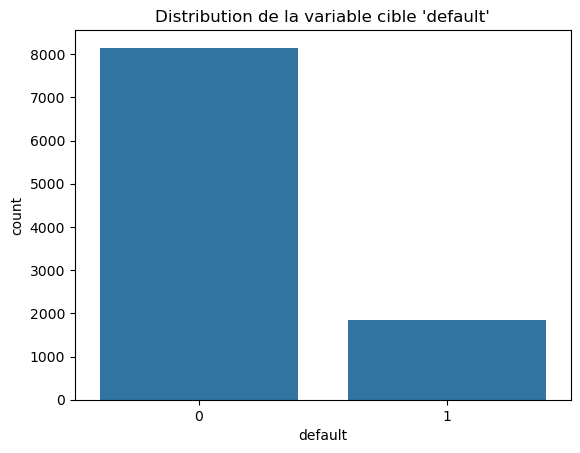

In [15]:
# --- 2.4.1 Visualisation de la distribution de la cible ---

import seaborn as sns
import matplotlib.pyplot as plt

# On utilise df_model (df sans 'customer_id') pour toutes les analyses/modélisation
# countplot affiche le nombre d'occurrences de chaque classe (0 = non défaut, 1 = défaut)
sns.countplot(x="default", data=df_model)

# Titre du graphique
plt.title("Distribution de la variable cible 'default'")

# Affichage du graphique
plt.show()

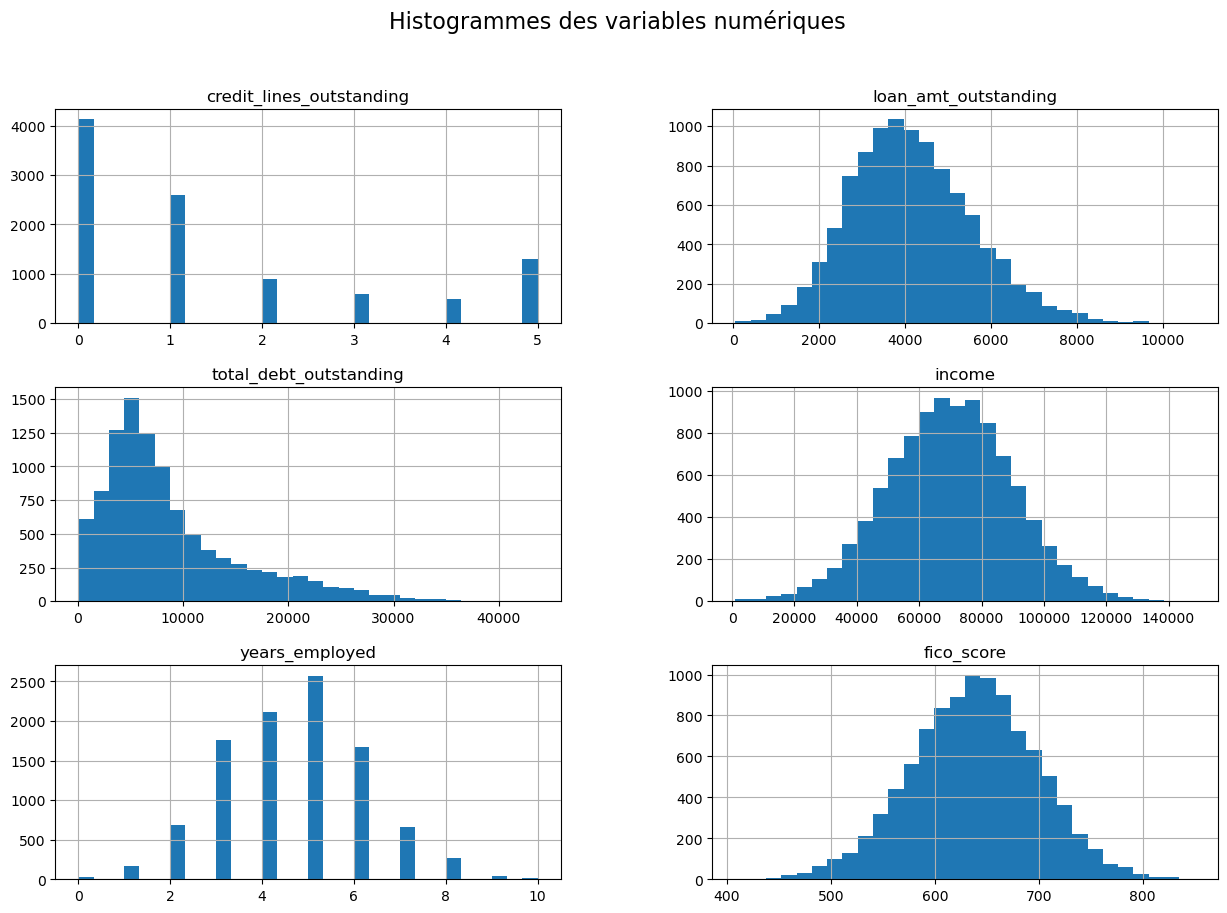

In [16]:
# --- 2.4.2 Distributions des variables numériques (Histogrammes) ---

# On sélectionne les colonnes numériques du DataFrame de modélisation (sans 'customer_id')
num_cols = df_model.select_dtypes(include=["int64", "float64"]).columns.tolist()

# On retire la cible 'default' : on ne veut pas l'inclure dans les features à visualiser
if "default" in num_cols:
    num_cols.remove("default")

# On trace un histogramme pour chaque variable numérique
# - bins=30 : nombre de barres dans l'histogramme
# - figsize=(15, 10) : taille globale de la figure
df_model[num_cols].hist(bins=30, figsize=(15, 10))

# Titre général
plt.suptitle("Histogrammes des variables numériques", fontsize=16)

# Affichage
plt.show()


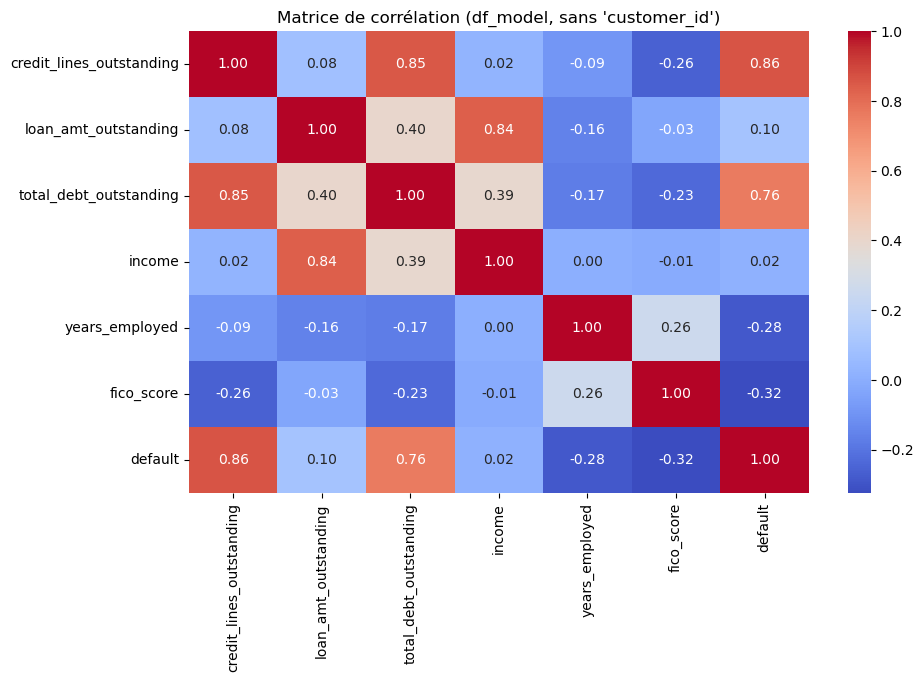

In [17]:
# --- 2.4.3 Matrice de corrélation (variables numériques + cible) ---

# On suppose que num_cols a été défini juste avant à partir de df_model
# (cf. étape 2.4.2) et qu'il NE contient PAS la cible 'default'.
# Si besoin, on peut le recalculer :
# num_cols = df_model.select_dtypes(include=["int64", "float64"]).columns.tolist()
# if "default" in num_cols: num_cols.remove("default")

plt.figure(figsize=(10, 6))

# Heatmap des corrélations :
# - on sélectionne les variables numériques + la cible 'default'
# - annot=True : affiche les coefficients
# - fmt=".2f" : 2 décimales
# - cmap="coolwarm" : bleu (corrélation négative) → rouge (positive)
sns.heatmap(
    df_model[num_cols + ["default"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

plt.title("Matrice de corrélation (df_model, sans 'customer_id')")
plt.show()



### 2.5 Relations clés entre les variables et la cible

Pour compléter l'analyse exploratoire, nous allons observer les différences
entre les clients en défaut (`default = 1`) et non défaut (`default = 0`) 
sur certaines variables importantes :

- **`income`** (revenu)
- **`fico_score`** (score de crédit)
- **`loan_amt_outstanding`** (montant du prêt en cours)

Nous utiliserons des **boxplots** pour comparer les distributions.


In [18]:
# --- 2.5 Relations clés entre variables et cible (boxplots interactifs) ---

import plotly.express as px

# Variables numériques à comparer à la cible 'default'
features_to_plot = ["income", "fico_score", "loan_amt_outstanding"]

# Astuce : si tu veux des libellés 0/1 bien séparés, tu peux caster 'default' en str :
# df_model["default_str"] = df_model["default"].astype(str)
# et remplacer x="default" par x="default_str" ci-dessous.

for col in features_to_plot:
    fig = px.box(
        df_model,
        x="default",          # classe cible (0 = non défaut, 1 = défaut)
        y=col,                # variable numérique à comparer
        color="default",      # couleur par classe
        points="all",         # affiche les points individuels
        title=f"{col} vs default (Boxplot interactif)"
    )
    fig.show()


## 3. Pré-traitement des données

Avant de pouvoir entraîner nos modèles de prédiction, il est nécessaire de préparer les données.  
Cette étape inclut :

- **3.1** Détection et suppression des doublons  
- **3.2** Suppression des colonnes non pertinentes (`customer_id`)  
- **3.3** Vérification des valeurs manquantes et définition d’une stratégie d’imputation  
- **3.4** Séparation du dataset en apprentissage (train) et test (80/20, stratifié)  
- **3.5** Construction d’un pipeline de pré-traitement (imputation + standardisation)  
- **3.6** Vérification du pipeline sur un échantillon (sanity check)

Ces étapes garantissent que nos données sont **propres, cohérentes et prêtes** pour l’entraînement des modèles.


### 3.1 Détection et suppression des doublons

- Vérifier les doublons sur `customer_id` (même client répété)
- Vérifier les doublons exacts de lignes
- Supprimer les doublons détectés avant de procéder au split


In [ ]:
# # Vérification de l'existence de la colonne 'customer_id' avant de rechercher des doublons spécifiques à cette colonne
# if "customer_id" in df.columns:
#     # Comptage du nombre de doublons basés uniquement sur la colonne 'customer_id'
#     dup_cust = df.duplicated(subset=["customer_id"]).sum()
#     print(f"Doublons sur customer_id : {dup_cust}")
    
#     # Suppression des doublons sur 'customer_id', en conservant la première occurrence uniquement, si des doublons sont détectés
#     if dup_cust > 0:
#         df = df.drop_duplicates(subset=["customer_id"], keep="first")
# else:
#     # Message informatif si la colonne 'customer_id' est absente du DataFrame
#     print("La colonne 'customer_id' n'existe pas dans le DataFrame.")

# # Comptage du nombre de doublons sur les lignes complètes (toutes colonnes)
# dup_rows = df.duplicated().sum()
# print(f"Doublons de lignes complètes : {dup_rows}")

# # Suppression des doublons complets, en conservant la première occurrence uniquement, si des doublons sont détectés
# if dup_rows > 0:
#     df = df.drop_duplicates(keep="first")

# # Affichage des dimensions du DataFrame après les suppressions éventuelles pour vérifier l'impact des opérations
# print("Dimensions après suppression potentielle :", df.shape)


Doublons sur customer_id : 0
Doublons de lignes complètes : 0
Dimensions après suppression potentielle : (10000, 8)


In [19]:
# --- 3.1 Détection et suppression des doublons ---

n_before = len(df)

# 1) Doublons sur customer_id (si la colonne existe)
if "customer_id" in df.columns:
    dup_cust = df.duplicated(subset=["customer_id"]).sum()
    print(f"Doublons sur customer_id : {dup_cust}")
    if dup_cust > 0:
        df = df.drop_duplicates(subset=["customer_id"], keep="first")
else:
    print("La colonne 'customer_id' n'existe pas dans le DataFrame.")

# 2) Doublons de lignes complètes
dup_rows = df.duplicated().sum()
print(f"Doublons de lignes complètes : {dup_rows}")
if dup_rows > 0:
    df = df.drop_duplicates(keep="first")

# 3) Reset index + log
df = df.reset_index(drop=True)
n_after = len(df)
print(f"Dimensions après nettoyage : {df.shape} (−{n_before - n_after} lignes)")


Doublons sur customer_id : 0
Doublons de lignes complètes : 0
Dimensions après nettoyage : (10000, 8) (−0 lignes)


### 3.2 Suppression des colonnes non pertinentes

- Retirer `customer_id` (identifiant, non informatif pour l’apprentissage)


In [ ]:
# # Liste des colonnes d'identifiants à supprimer (ex: identifiants uniques non utiles pour l'analyse)
# ID_COLS = ["customer_id"]

# # Création d'une liste des colonnes à supprimer uniquement si elles existent dans le DataFrame
# cols_to_drop = [c for c in ID_COLS if c in df.columns]

# # Suppression des colonnes identifiées du DataFrame
# df = df.drop(columns=cols_to_drop)

# # Affichage des colonnes supprimées pour vérification
# print("Colonnes supprimées :", cols_to_drop)

# # Affichage des colonnes restantes après suppression
# print("Colonnes restantes :", df.columns.tolist())


Colonnes supprimées : ['customer_id']
Colonnes restantes : ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']


In [20]:
# --- 3.2 Suppression des colonnes non pertinentes ---

# Colonnes identifiants à exclure des features (non prédictives)
ID_COLS = ["customer_id"]

# On ne supprime que les colonnes qui existent réellement dans df
cols_to_drop = [c for c in ID_COLS if c in df.columns]

# Suppression des colonnes non pertinentes
df = df.drop(columns=cols_to_drop)

# Journalisation : ce qui a été supprimé et ce qu'il reste
print("Colonnes supprimées :", cols_to_drop)
print("Colonnes restantes :", df.columns.tolist())

# On fige un DataFrame de travail pour la suite de la modélisation
# (évite toute ambiguïté avec df utilisé plus haut pour l'EDA)
df_model = df.copy()


Colonnes supprimées : ['customer_id']
Colonnes restantes : ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']


### 3.3 Vérification des valeurs manquantes et stratégie d’imputation

- Quantifier les valeurs manquantes par variable
- Décider d’une stratégie d’imputation (médiane pour numériques)


In [ ]:
# # Calcul du nombre de valeurs manquantes (NaN) par colonne
# na_counts = df.isna().sum().sort_values(ascending=False)

# # Affichage du nombre de valeurs manquantes par colonne, trié de la plus grande à la plus petite
# print("Valeurs manquantes par colonne :")
# print(na_counts)

# # Option supplémentaire : calcul du pourcentage de valeurs manquantes par colonne
# na_pct = (df.isna().mean() * 100).round(2)

# # Affichage du pourcentage de valeurs manquantes par colonne, arrondi à 2 décimales
# print("\nPourcentage de valeurs manquantes :")
# print(na_pct)


Valeurs manquantes par colonne :
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

Pourcentage de valeurs manquantes :
credit_lines_outstanding    0.0
loan_amt_outstanding        0.0
total_debt_outstanding      0.0
income                      0.0
years_employed              0.0
fico_score                  0.0
default                     0.0
dtype: float64


In [21]:
# --- 3.3 Vérification des valeurs manquantes & stratégie d’imputation ---

# On vérifie les NaN sur le DataFrame de modélisation (df_model)
na_counts = df_model.isna().sum().sort_values(ascending=False)

print("Valeurs manquantes par colonne (nb) :")
print(na_counts)

# Pourcentage de NaN (plus lisible quand il y en a peu)
na_pct = (df_model.isna().mean() * 100).round(2)
print("\nValeurs manquantes par colonne (%) :")
print(na_pct)

# (Optionnel) Focus uniquement sur les colonnes qui ont au moins 1 NaN
na_nonzero = na_counts[na_counts > 0]
if len(na_nonzero) == 0:
    print("\n✅ Aucune valeur manquante détectée — imputation par médiane restera sans effet (sécurise le pipeline).")
else:
    print("\n⚠️ Colonnes avec NaN détectés (à imputer) :")
    print(na_nonzero)


Valeurs manquantes par colonne (nb) :
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

Valeurs manquantes par colonne (%) :
credit_lines_outstanding    0.0
loan_amt_outstanding        0.0
total_debt_outstanding      0.0
income                      0.0
years_employed              0.0
fico_score                  0.0
default                     0.0
dtype: float64

✅ Aucune valeur manquante détectée — imputation par médiane restera sans effet (sécurise le pipeline).


### 3.4 Séparation train / test (stratifiée)

- Définir la cible `default`
- Séparer en apprentissage (80%) et test (20%) en conservant le ratio de classes


In [ ]:
# from sklearn.model_selection import train_test_split  # Import de la fonction de split

# # Définition du nom de la variable cible
# TARGET = "default"

# # Création de la liste des variables explicatives (toutes les colonnes sauf la cible)
# FEATURES = [c for c in df.columns if c != TARGET]

# # Séparation des features (X) et de la cible (y)
# X = df[FEATURES].copy()          # Copie des variables explicatives
# y = df[TARGET].astype(int).copy()  # Copie de la variable cible convertie en entier (au cas où)

# # Séparation en jeu d'entraînement et de test
# # - test_size=0.2 : 20% des données pour le test, 80% pour l'entraînement
# # - stratify=y : conserve la proportion des classes de la cible dans chaque ensemble (important si classes déséquilibrées)
# # - random_state=42 : fixe la graine aléatoire pour reproductibilité
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # Affichage des dimensions des ensembles générés
# print("Train :", X_train.shape, "| Test :", X_test.shape)

# # Vérification du taux de défaut dans chaque ensemble
# print("Taux de défaut - train:", y_train.mean().round(3), "| test:", y_test.mean().round(3))


Train : (8000, 6) | Test : (2000, 6)
Taux de défaut - train: 0.185 | test: 0.185


In [22]:
# --- 3.4 Séparation train / test (stratifiée) ---

from sklearn.model_selection import train_test_split

# Nom de la cible
TARGET = "default"

# On travaille sur le DataFrame de modélisation (df_model), déjà sans 'customer_id'
# -> FEATURES = toutes les colonnes sauf la cible
FEATURES = [c for c in df_model.columns if c != TARGET]

# Séparation features / cible
X = df_model[FEATURES].copy()
y = df_model[TARGET].astype(int).copy()  # on force en int par sécurité

# Split stratifié pour conserver le ratio de classes entre train et test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% test / 80% train
    stratify=y,         # conserve la proportion de la classe minoritaire
    random_state=42     # reproductibilité
)

# (Optionnel) garder l'ordre exact des colonnes pour l'app de déploiement
FEATURE_ORDER = FEATURES

# Contrôles rapides
print("Train :", X_train.shape, "| Test :", X_test.shape)
print("Taux de défaut - train:", y_train.mean().round(3), "| test:", y_test.mean().round(3))


Train : (8000, 6) | Test : (2000, 6)
Taux de défaut - train: 0.185 | test: 0.185


### 3.5 Pipeline de pré-traitement

- Imputation **médiane** pour toutes les variables numériques
- Standardisation (**StandardScaler**) pour homogénéiser les échelles


In [ ]:
# from sklearn.compose import ColumnTransformer          # Pour appliquer des traitements différents selon les colonnes
# from sklearn.pipeline import Pipeline                  # Pour chaîner plusieurs étapes dans un flux unique
# from sklearn.impute import SimpleImputer               # Pour gérer les valeurs manquantes
# from sklearn.preprocessing import StandardScaler       # Pour standardiser les variables numériques

# # Sélection des colonnes numériques (ici, toutes les colonnes sont numériques)
# num_cols = X_train.columns.tolist()

# # Définition d’un pipeline de prétraitement :
# # - Imputation des valeurs manquantes avec la médiane
# # - Standardisation des variables (moyenne = 0, écart-type = 1)
# preproc = ColumnTransformer(transformers=[
#     ("num", Pipeline(steps=[
#         ("imputer", SimpleImputer(strategy="median")),  # Remplace les NaN par la médiane
#         ("scaler", StandardScaler())                    # Met à l’échelle les données
#     ]), num_cols)                                       # Appliquer ce pipeline à toutes les colonnes numériques
# ])

# # Affichage de la structure du préprocesseur
# preproc


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['credit_lines_outstanding',
                                  'loan_amt_outstanding',
                                  'total_debt_outstanding', 'income',
                                  'years_employed', 'fico_score'])])

In [23]:
# --- 3.5 Pipeline de pré-traitement ---

from sklearn.compose import ColumnTransformer      # Pour cibler des groupes de colonnes
from sklearn.pipeline import Pipeline              # Pour chaîner les étapes
from sklearn.impute import SimpleImputer           # Gestion des valeurs manquantes
from sklearn.preprocessing import StandardScaler   # Mise à l'échelle

# Ici, toutes les features sont numériques → on sélectionne simplement toutes les colonnes de X_train
num_cols = X_train.columns.tolist()

# Pipeline de pré-traitement appliqué aux colonnes numériques :
# 1) Imputation par la médiane (robuste aux outliers)
# 2) Standardisation (moyenne=0, écart-type=1) pour aider certains modèles (ex: régression logistique)
preproc = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]),
            num_cols
        )
    ],
    remainder="drop"  # Ici inutile car toutes les colonnes sont numériques, mais on explicite le comportement
)

# Affiche la structure du préprocesseur (utile en debug / soutenance)
preproc


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['credit_lines_outstanding',
                                  'loan_amt_outstanding',
                                  'total_debt_outstanding', 'income',
                                  'years_employed', 'fico_score'])])

### 3.6 Sanity check du pipeline

- Vérifier que le pipeline `fit_transform` fonctionne sur le train
- Appliquer `transform` sur le test sans erreur


In [24]:
# Application du pipeline de prétraitement (fit + transform) sur les données d'entraînement
Xt_train = preproc.fit_transform(X_train)

# Application du pipeline de prétraitement (transform seul) sur les données de test
Xt_test  = preproc.transform(X_test)

# Affichage des dimensions des matrices transformées
print("Shape Xt_train :", Xt_train.shape)
print("Shape Xt_test  :", Xt_test.shape)


Shape Xt_train : (8000, 6)
Shape Xt_test  : (2000, 6)


## 4. Modélisation

Une fois les données préparées, nous passons à l’entraînement des modèles de classification.  
L’objectif est de comparer plusieurs algorithmes afin de sélectionner celui qui offre les meilleures performances pour la **prédiction du risque de défaut de paiement**.

Nous adopterons une approche expérimentale, traçant et évaluant nos modèles avec **MLflow** pour assurer la traçabilité MLOps.

Le processus est structuré en plusieurs sous-sections :

- **4.1** Définition des métriques d’évaluation  
- **4.2** Entraînement d’un modèle de **régression logistique**  
- **4.3** Entraînement d’un **arbre de décision**  
- **4.4** Entraînement d’une **forêt aléatoire (Random Forest)**  
- **4.5** Comparaison des résultats obtenus (tableau récapitulatif)  
- **4.6** Sélection du meilleur modèle et calibration éventuelle  

Ces étapes permettront d’identifier un modèle **robuste**, **interprétable** et **prêt à être déployé** en production.



### 4.1 Définition des métriques d’évaluation

Pour évaluer la performance de nos modèles, nous utiliserons plusieurs métriques complémentaires :

- **ROC-AUC** : mesure la capacité du modèle à discriminer entre défaut et non défaut, indépendamment d’un seuil.  
- **PR-AUC (Average Precision)** : adaptée aux classes déséquilibrées, elle évalue la précision en fonction du rappel.  
- **Brier Score** : mesure la qualité de calibration des probabilités prédites (plus c’est bas, mieux c’est).  
- **Matrice de confusion** : permet d’observer les vrais positifs/négatifs et faux positifs/négatifs après choix d’un seuil.  
- **Rapport de classification** (précision, rappel, F1-score).

Ces métriques nous donneront une vision complète de la performance et de la fiabilité des modèles.


In [ ]:
# from sklearn.metrics import (
#     roc_auc_score, average_precision_score, brier_score_loss,
#     confusion_matrix, classification_report
# )

# def eval_model(model, X_train, y_train, X_test, y_test, threshold=0.5):
#     """
#     Entraîne un modèle et renvoie un dictionnaire contenant :
#     - Plusieurs métriques de performance (AUC, PR AUC, Brier score)
#     - La matrice de confusion
#     - Le rapport de classification (precision, recall, f1-score)
    
#     Parameters:
#         model : modèle sklearn (doit implémenter .fit() et .predict_proba())
#         X_train : données d'entraînement (features)
#         y_train : labels d'entraînement
#         X_test : données de test (features)
#         y_test : labels de test
#         threshold : seuil de classification pour convertir les probabilités en classes (défaut = 0.5)
    
#     Returns:
#         dict : un dictionnaire avec les métriques et les prédictions
#     """

#     # Entraînement du modèle sur les données d'entraînement
#     model.fit(X_train, y_train)

#     # Probabilités prédites (classe 1) sur train et test
#     proba_train = model.predict_proba(X_train)[:, 1]
#     proba_test  = model.predict_proba(X_test)[:, 1]  # ✅ Correction de la faute de frappe 'predic_proba'

#     # Calcul des scores de performance
#     results = {
#         "roc_auc_train": roc_auc_score(y_train, proba_train),                      # AUC ROC sur train
#         "roc_auc_test":  roc_auc_score(y_test, proba_test),                        # AUC ROC sur test
#         "pr_auc_train":  average_precision_score(y_train, proba_train),            # AUC PR sur train
#         "pr_auc_test":   average_precision_score(y_test, proba_test),              # AUC PR sur test
#         "brier_test":    brier_score_loss(y_test, proba_test),                     # Brier score (calibration) sur test
#     }

#     # Prédictions binaires en appliquant le seuil
#     preds = (proba_test >= threshold).astype(int)

#     # Matrice de confusion et rapport de classification
#     results["confusion_matrix"] = confusion_matrix(y_test, preds).tolist()
#     results["classification_report"] = classification_report(y_test, preds, digits=3)

#     return results



In [25]:
# --- 4.1 Définition des métriques d’évaluation (fonction générique) ---

from typing import Dict, Any
import numpy as np
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, classification_report
)

def _get_proba(estimator, X) -> np.ndarray:
    """
    Renvoie la probabilité de la classe positive pour chaque échantillon.
    - Utilise predict_proba si disponible.
    - Sinon, fallback sur decision_function avec une sigmoïde (approx proba).
    - En dernier recours, utilise predict (peu informatif pour AUC/PR).
    """
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    elif hasattr(estimator, "decision_function"):
        scores = estimator.decision_function(X)
        return 1 / (1 + np.exp(-scores))  # transformation sigmoïde
    else:
        # Dernier recours : valeurs 0/1 converties en float
        return estimator.predict(X).astype(float)

def eval_model(model, X_train, y_train, X_test, y_test, threshold: float = 0.5) -> Dict[str, Any]:
    """
    Entraîne un estimateur (ou Pipeline sklearn) et calcule des métriques complètes.

    Paramètres
    ----------
    model : sklearn estimator ou Pipeline
        Doit implémenter .fit() et de préférence .predict_proba() ou .decision_function().
    X_train, y_train : array-like
        Données d'entraînement (features et cible).
    X_test, y_test : array-like
        Données de test (features et cible).
    threshold : float, par défaut 0.5
        Seuil pour convertir les probabilités en classes (0/1).

    Retour
    ------
    Dict[str, Any] :
        - 'roc_auc_train' / 'roc_auc_test' : AUC ROC
        - 'pr_auc_train' / 'pr_auc_test'   : Average Precision (aire PR)
        - 'brier_test'                     : Brier score sur test (calibration)
        - 'threshold'                      : seuil utilisé
        - 'confusion_matrix'               : matrice de confusion @ threshold
        - 'classification_report'          : précision/rappel/F1 formaté
        - 'y_test' / 'proba_test' / 'preds_test' : utiles pour tracés/analyses
    """
    # 1) Entraînement
    model.fit(X_train, y_train)

    # 2) Probabilités (train/test)
    proba_train = _get_proba(model, X_train)
    proba_test  = _get_proba(model, X_test)

    # 3) Métriques principales
    results: Dict[str, Any] = {
        "roc_auc_train": float(roc_auc_score(y_train, proba_train)),
        "roc_auc_test":  float(roc_auc_score(y_test,  proba_test)),
        "pr_auc_train":  float(average_precision_score(y_train, proba_train)),
        "pr_auc_test":   float(average_precision_score(y_test,  proba_test)),
        "brier_test":    float(brier_score_loss(y_test, proba_test)),
        "threshold":     float(threshold),
    }

    # 4) Prédictions binaires @ threshold
    preds = (proba_test >= threshold).astype(int)

    # 5) Détails de classification
    results["confusion_matrix"] = confusion_matrix(y_test, preds).tolist()
    results["classification_report"] = classification_report(y_test, preds, digits=3)

    # 6) Objets utiles pour tracés ultérieurs (ROC/PR) et sauvegardes
    results["y_test"] = y_test.tolist()
    results["proba_test"] = proba_test.tolist()
    results["preds_test"] = preds.tolist()

    return results


### 4.2 Régression Logistique

La régression logistique est un modèle de base, interprétable et largement utilisé dans le scoring de crédit.  
Nous allons l’entraîner sur nos données pré-traitées et évaluer ses performances avec les métriques définies en 4.1.


In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline

# # Modèle de régression logistique avec pondération équilibrée
# logreg = Pipeline(steps=[
#     ("preproc", preproc),
#     ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
# ])

# # Évaluation avec la fonction définie en 4.1
# logreg_results = eval_model(logreg, X_train, y_train, X_test, y_test, threshold=0.5)

# print("Résultats Régression Logistique :")
# for k, v in logreg_results.items():
#     if k not in ["confusion_matrix", "classification_report"]:
#         print(f"{k}: {v:.3f}")

# print("\nMatrice de confusion :", logreg_results["confusion_matrix"])
# print("\nRapport de classification :\n", logreg_results["classification_report"])


#### 4.2.1 Entraînement – Régression logistique

Nous entraînons un modèle de **régression logistique** encapsulé dans un pipeline
qui applique le **pré-traitement** (`preproc`) puis l’estimateur.
  
Cette étape ajuste le modèle sur l’échantillon **train**.



In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline

# # Création d'un pipeline combinant le prétraitement et le modèle
# logreg = Pipeline(steps=[
#     ("preproc", preproc),  # Étape 1 : prétraitement (imputation + standardisation)
#     ("clf", LogisticRegression(
#         max_iter=2000,            # Augmente le nombre d’itérations pour assurer la convergence
#         class_weight="balanced", # Gère les classes déséquilibrées automatiquement
#         random_state=42          # Graine aléatoire pour reproductibilité
#     ))
# ])

# # Entraînement du modèle sur les données d'entraînement
# logreg.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['credit_lines_outstanding',
                                                   'loan_amt_outstanding',
                                                   'total_debt_outstanding',
                                                   'income', 'years_employed',
                                                   'fico_score'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42))])

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Pipeline = prétraitement + modèle
logreg = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs",     # optionnel, mais explicite
        random_state=42
    ))
])

# Évaluation (eval_model fait le .fit() en interne)
logreg_metrics = eval_model(
    model=logreg,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    threshold=0.5
)

print("AUC ROC (test):", round(logreg_metrics["roc_auc_test"], 3))
print("PR AUC  (test):", round(logreg_metrics["pr_auc_test"], 3))
print("Brier   (test):", round(logreg_metrics["brier_test"], 4))
print("\nRapport de classification @0.5:\n", logreg_metrics["classification_report"])


AUC ROC (test): 1.0
PR AUC  (test): 1.0
Brier   (test): 0.0047

Rapport de classification @0.5:
               precision    recall  f1-score   support

           0      1.000     0.994     0.997      1630
           1      0.976     1.000     0.988       370

    accuracy                          0.996      2000
   macro avg      0.988     0.997     0.993      2000
weighted avg      0.996     0.996     0.996      2000



#### 4.2.2 Affichage des performances du modèle

Les performances du modèle de **régression logistique** ont été évaluées automatiquement 
dans la fonction `eval_model()` (qui effectue à la fois l’entraînement et le calcul des métriques principales).

Nous affichons ici les résultats obtenus sur l’échantillon **test** :

- **ROC-AUC** : mesure la capacité du modèle à distinguer défaut vs non défaut,  
- **PR-AUC** : adaptée aux classes déséquilibrées,  
- **Brier Score** : évalue la qualité de la calibration des probabilités,  
- **Matrice de confusion** et **rapport de classification** : détaillent les prédictions au seuil 0,5.


In [ ]:
# Réutilisation des résultats calculés par eval_model (aucun fit ici)

import numpy as np

print("===== Évaluation Régression Logistique =====")
print(f"ROC-AUC (test)  : {logreg_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test)  : {logreg_metrics['pr_auc_test']:.3f}")
print(f"Brier score     : {logreg_metrics['brier_test']:.4f}")
print("--------------------------------------------")
print("Matrice de confusion :\n", np.array(logreg_metrics["confusion_matrix"]))
print("--------------------------------------------")
print("Rapport de classification :")
print(logreg_metrics["classification_report"])


#### 4.2.2 Évaluation des performances (test)

Nous évaluons le modèle sur l’échantillon **test** avec les métriques principales :
- **ROC-AUC** (discrimination globale),
- **PR-AUC** (adaptée aux classes déséquilibrées),
- **Brier score** (calibration des probabilités).

Nous affichons également :
- la **matrice de confusion** (valeurs numériques),
- le **rapport de classification** (précision, rappel, F1-score),  
au **seuil de probabilité 0,5**.

##----A ertirer et garder celui du haut car redondant -----


In [ ]:
# from sklearn.metrics import (
#     roc_auc_score, average_precision_score,
#     brier_score_loss, confusion_matrix,
#     classification_report
# )

# # Prédiction des probabilités pour la classe 1 (défaut de crédit)
# proba_test = logreg.predict_proba(X_test)[:, 1]

# # Application du seuil de 0.5 pour obtenir des prédictions binaires
# preds = (proba_test >= 0.5).astype(int)

# # Affichage des métriques de performance
# print("===== Évaluation Régression Logistique =====")
# print(f"ROC-AUC (test)  : {roc_auc_score(y_test, proba_test):.3f}")               # Discrimination globale
# print(f"PR-AUC  (test)  : {average_precision_score(y_test, proba_test):.3f}")    # Precision-Recall AUC (utile en déséquilibre)
# print(f"Brier score     : {brier_score_loss(y_test, proba_test):.3f}")           # Qualité de la calibration des probabilités

# print("--------------------------------------------")
# print("Matrice de confusion :")
# print(confusion_matrix(y_test, preds))  # Nombre de VP, VN, FP, FN

# print("--------------------------------------------")
# print("Rapport de classification :")
# print(classification_report(y_test, preds, digits=3))  # Détail des scores (précision, rappel, F1)



===== Évaluation Régression Logistique =====
ROC-AUC (test)  : 1.000
PR-AUC  (test)  : 1.000
Brier score     : 0.005
--------------------------------------------
Matrice de confusion :
[[1621    9]
 [   0  370]]
--------------------------------------------
Rapport de classification :
              precision    recall  f1-score   support

           0      1.000     0.994     0.997      1630
           1      0.976     1.000     0.988       370

    accuracy                          0.996      2000
   macro avg      0.988     0.997     0.993      2000
weighted avg      0.996     0.996     0.996      2000



#### 4.2.3 Interprétation et visualisation de la matrice de confusion

Afin de rendre l’évaluation plus lisible :

- Nous affichons **les valeurs numériques** de la matrice de confusion sous forme de texte :
  - **TN (True Negatives)** : nombre de non-défauts correctement prédits  
  - **FP (False Positives)** : nombre de non-défauts classés à tort comme défauts  
  - **FN (False Negatives)** : nombre de défauts non détectés  
  - **TP (True Positives)** : nombre de défauts correctement identifiés  

- Nous représentons ensuite la matrice de confusion sous forme de **heatmap**
(carte thermique) pour une lecture visuelle immédiate et intuitive.

## ---Redonda,t a retirer _____



In [38]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calcul de la matrice de confusion
# cm = confusion_matrix(y_test, preds)

# # ✅ Message texte explicatif
# print("===== Matrice de confusion – Régression Logistique =====")
# print("Lignes = Valeurs réelles | Colonnes = Prédictions")
# print(f"Vrais négatifs (TN) : {cm[0,0]}")
# print(f"Faux positifs  (FP) : {cm[0,1]}")
# print(f"Faux négatifs  (FN) : {cm[1,0]}")
# print(f"Vrais positifs  (TP) : {cm[1,1]}")

# # ✅ Affichage visuel
# plt.figure(figsize=(5, 4))
# sns.heatmap(cm,
#             annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=["Prédit: 0", "Prédit: 1"],
#             yticklabels=["Réel: 0", "Réel: 1"])
# plt.title("Matrice de confusion – Régression Logistique")
# plt.xlabel("Prédictions")
# plt.ylabel("Réalité")
# plt.tight_layout()
# plt.show()



===== Matrice de confusion – Régression Logistique =====
Lignes = Valeurs réelles | Colonnes = Prédictions

Vrais négatifs (TN) : 1621
Faux positifs  (FP) : 9
Faux négatifs  (FN) : 0
Vrais positifs  (TP) : 370

Exactitude globale (accuracy) : 99.550%


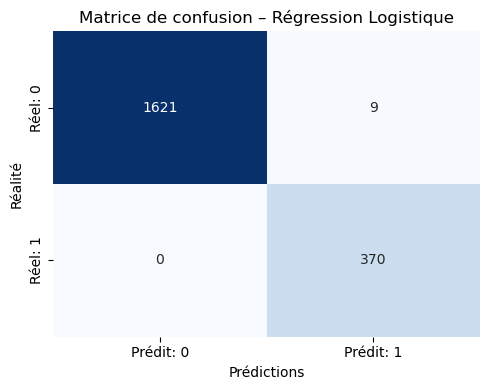

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 📌 Calcul de la matrice de confusion
cm = confusion_matrix(y_test, preds)

# ✅ Message texte explicatif
print("===== Matrice de confusion – Régression Logistique =====")
print("Lignes = Valeurs réelles | Colonnes = Prédictions\n")

# Décomposition de la matrice pour interprétation
TN = cm[0, 0]  # Vrais négatifs
FP = cm[0, 1]  # Faux positifs
FN = cm[1, 0]  # Faux négatifs
TP = cm[1, 1]  # Vrais positifs

# ✅ Affichage détaillé
print(f"Vrais négatifs (TN) : {TN}")
print(f"Faux positifs  (FP) : {FP}")
print(f"Faux négatifs  (FN) : {FN}")
print(f"Vrais positifs  (TP) : {TP}")

# ✅ Calcul et affichage de l'accuracy (exactitude globale)
accuracy = (TP + TN) / cm.sum()
print(f"\nExactitude globale (accuracy) : {accuracy:.3%}")

# ✅ Affichage visuel (heatmap)
plt.figure(figsize=(5, 4))
sns.heatmap(cm,
            annot=True,           # Affiche les valeurs dans chaque case
            fmt="d",              # Format entier
            cmap="Blues",         # Palette de couleurs
            cbar=False,           # Pas de barre de couleur
            xticklabels=["Prédit: 0", "Prédit: 1"],  # Étiquettes colonnes
            yticklabels=["Réel: 0", "Réel: 1"])      # Étiquettes lignes

# ✅ Titres et labels
plt.title("Matrice de confusion – Régression Logistique")
plt.xlabel("Prédictions")
plt.ylabel("Réalité")
plt.tight_layout()
plt.show()


#### 4.2.3 Interprétation et visualisation de la matrice de confusion

Nous interprétons ici les résultats au **seuil 0,5**, en **réutilisant les sorties de `eval_model`**  
(aucun ré-entraînement ni nouvelle prédiction).

- **TN (True Negatives)** : non-défauts correctement prédits  
- **FP (False Positives)** : non-défauts prédits à tort comme défauts  
- **FN (False Negatives)** : défauts non détectés (erreurs critiques côté risque)  
- **TP (True Positives)** : défauts correctement identifiés  

Nous affichons :
1) les **valeurs numériques** de la matrice de confusion pour une lecture précise ;  
2) une **heatmap** (carte thermique) pour une visualisation immédiate.

> Remarque : sur un jeu **déséquilibré**, l’accuracy peut être trompeuse ; on privilégie **ROC-AUC**, **PR-AUC**, et le **Recall** selon le coût métier des FN/FP.


===== Matrice de confusion – Régression Logistique =====
Lignes = Valeurs réelles | Colonnes = Prédictions

Vrais négatifs (TN) : 1621
Faux positifs  (FP) : 9
Faux négatifs  (FN) : 0
Vrais positifs  (TP) : 370

Exactitude globale (accuracy) : 99.550%


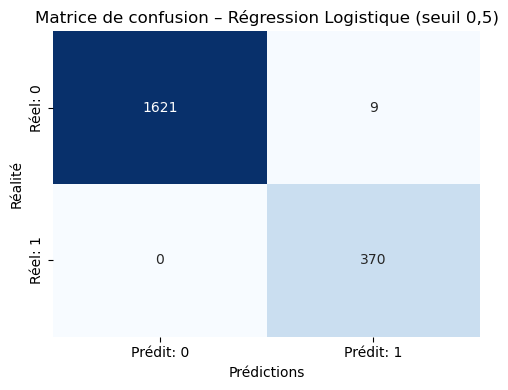

In [28]:
# --- 4.2.3 Interprétation et visualisation de la matrice de confusion ---

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# On réutilise les sorties de eval_model (aucun fit ni prédiction ici)
y_true = np.array(logreg_metrics["y_test"])
y_pred = np.array(logreg_metrics["preds_test"])

# 📌 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

print("===== Matrice de confusion – Régression Logistique =====")
print("Lignes = Valeurs réelles | Colonnes = Prédictions\n")

# Décomposition pour interprétation
TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

print(f"Vrais négatifs (TN) : {TN}")
print(f"Faux positifs  (FP) : {FP}")
print(f"Faux négatifs  (FN) : {FN}")
print(f"Vrais positifs  (TP) : {TP}")

# ✅ Exactitude globale (attention : à ne pas confondre avec AUC/F1)
accuracy = (TP + TN) / cm.sum()
print(f"\nExactitude globale (accuracy) : {accuracy:.3%}")

# 🔥 Heatmap pour lecture visuelle
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True, fmt="d", cbar=False,
    cmap="Blues",
    xticklabels=["Prédit: 0", "Prédit: 1"],
    yticklabels=["Réel: 0", "Réel: 1"]
)
plt.title("Matrice de confusion – Régression Logistique (seuil 0,5)")
plt.xlabel("Prédictions")
plt.ylabel("Réalité")
plt.tight_layout()
plt.show()


### 4.3 Arbre de Décision

L’arbre de décision est un modèle simple et interprétable, qui segmente les
données en suivant une logique de règles « si… alors… ».  
Nous allons l’entraîner, évaluer ses performances puis visualiser la matrice de confusion.


### 4.3.1 Arbre de Décision

L’arbre de décision est un modèle simple et interprétable, qui segmente les
données en suivant une logique de règles « si… alors… ».  
Nous allons l’entraîner, évaluer ses performances puis visualiser la matrice de confusion.
## ----- A retirer REDONDANT ----


In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline

# # Pipeline : prétraitement + arbre de décision
# tree = Pipeline(steps=[
#     ("preproc", preproc),  # Prétraitement (imputation + standardisation)
#     ("clf", DecisionTreeClassifier(
#         max_depth=6,              # Profondeur limitée pour éviter le surapprentissage
#         class_weight="balanced", # Pondération automatique des classes
#         random_state=42          # Reproductibilité
#     ))
# ])

# # Entraînement du modèle sur les données d'entraînement
# tree.fit(X_train, y_train)



Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['credit_lines_outstanding',
                                                   'loan_amt_outstanding',
                                                   'total_debt_outstanding',
                                                   'income', 'years_employed',
                                                   'fico_score'])])),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                                        random_state=42))])

#### 4.3.1 Entraînement et évaluation – Arbre de Décision

L’arbre de décision est un modèle simple et interprétable, basé sur une succession
de règles de type **« si… alors… »**.

Nous entraînons ici un **pipeline complet** combinant :
- le **pré-traitement** des variables (imputation + standardisation),
- un **arbre de décision** limité en profondeur (`max_depth=6`)
  pour éviter le surapprentissage,
- et une **pondération automatique des classes** (`class_weight="balanced"`)
  afin de compenser le déséquilibre de la variable cible.

L’évaluation est réalisée via la fonction `eval_model()` qui calcule :
- ROC-AUC, PR-AUC et Brier score,
- le rapport de classification détaillé au seuil 0,5.


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# --- 4.3.1 Entraînement et évaluation - Arbre de Décision ---

# Pipeline = prétraitement + modèle
tree = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", DecisionTreeClassifier(
        max_depth=6,              # Profondeur limitée pour éviter l’overfitting
        class_weight="balanced",  # Pondération automatique des classes
        random_state=42
    ))
])

# Évaluation complète via eval_model (fit + métriques)
tree_metrics = eval_model(
    model=tree,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    threshold=0.5
)

# Résumé rapide des résultats
print("===== Évaluation Arbre de Décision =====")
print(f"ROC-AUC (test) : {tree_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test) : {tree_metrics['pr_auc_test']:.3f}")
print(f"Brier score    : {tree_metrics['brier_test']:.4f}")
print("--------------------------------------------")
print("Rapport de classification :")
print(tree_metrics["classification_report"])


NameError: name 'preproc' is not defined

#### 4.3.2 Affichage des performances (test)

Les performances de l’**arbre de décision** ont été calculées par `eval_model()`  
(qui effectue à la fois l’entraînement et l’évaluation).  
Nous affichons ici les métriques **déjà calculées** sur le set **test**.


In [ ]:
# --- 4.3.2 Affichage des performances (test) ---

# On réutilise les résultats calculés par eval_model (aucun fit ni predict_proba ici)
import numpy as np

print("===== Évaluation Arbre de Décision =====")
print(f"ROC-AUC (test)  : {tree_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test)  : {tree_metrics['pr_auc_test']:.3f}")
print(f"Brier score     : {tree_metrics['brier_test']:.4f}")
print("--------------------------------------------")

# Matrice de confusion (déjà calculée au seuil 0.5 par eval_model)
cm = np.array(tree_metrics["confusion_matrix"])
print("Matrice de confusion :\n", cm)

print("--------------------------------------------")
print("Rapport de classification :")
print(tree_metrics["classification_report"])



#### 4.3.2 Évaluation des performances (test)

Nous évaluons l’arbre de décision avec les mêmes métriques que précédemment :  
- **ROC-AUC**  
- **PR-AUC**  
- **Brier score**  
- **Matrice de confusion** et **rapport de classification**
# ----- A rettirer REDONDANT------


In [ ]:
# from sklearn.metrics import (
#     roc_auc_score, average_precision_score,
#     brier_score_loss, confusion_matrix,
#     classification_report
# )

# # Prédiction des probabilités pour la classe 1
# proba_test_tree = tree.predict_proba(X_test)[:, 1]

# # Application d’un seuil de 0.5 pour générer les prédictions binaires
# preds_tree = (proba_test_tree >= 0.5).astype(int)

# # Affichage des métriques
# print("===== Évaluation Arbre de Décision =====")
# print(f"ROC-AUC (test)  : {roc_auc_score(y_test, proba_test_tree):.3f}")
# print(f"PR-AUC  (test)  : {average_precision_score(y_test, proba_test_tree):.3f}")
# print(f"Brier score     : {brier_score_loss(y_test, proba_test_tree):.3f}")
# print("--------------------------------------------")
# print("Matrice de confusion (Arbre de Décision) :")
# print(confusion_matrix(y_test, preds_tree))
# print("--------------------------------------------")
# print("Rapport de classification (Arbre de Décision) :")
# print(classification_report(y_test, preds_tree, digits=3))



===== Évaluation Arbre de Décision =====
ROC-AUC (test)  : 0.997
PR-AUC  (test)  : 0.995
Brier score     : 0.004
--------------------------------------------
Matrice de confusion (Arbre de Décision) :
[[1623    7]
 [   2  368]]
--------------------------------------------
Rapport de classification (Arbre de Décision) :
              precision    recall  f1-score   support

           0      0.999     0.996     0.997      1630
           1      0.981     0.995     0.988       370

    accuracy                          0.996      2000
   macro avg      0.990     0.995     0.993      2000
weighted avg      0.996     0.996     0.996      2000



#### 4.3.3 Interprétation et visualisation de la matrice de confusion

Comme pour la régression logistique, nous affichons :  
- Les **valeurs numériques** (TN, FP, FN, TP) pour comprendre les erreurs  
- La **heatmap** (carte thermique) pour une lecture visuelle intuitive
# --- A retirer RDONDANT ------


===== Matrice de confusion – Arbre de Décision =====
Lignes = Valeurs réelles | Colonnes = Prédictions

Vrais négatifs (TN) : 1623
Faux positifs  (FP) : 7
Faux négatifs  (FN) : 2
Vrais positifs  (TP) : 368

Exactitude globale (accuracy) : 99.550%


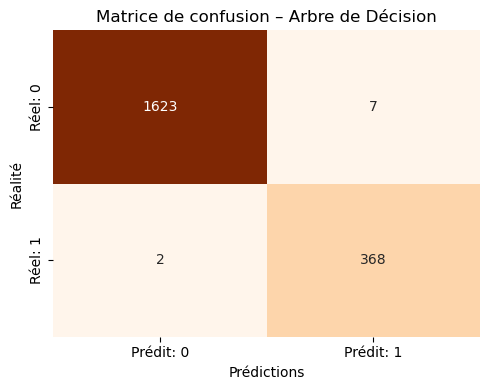

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calcul de la matrice de confusion
# cm_tree = confusion_matrix(y_test, preds_tree)

# # ✅ Affichage explicatif des valeurs
# print("===== Matrice de confusion – Arbre de Décision =====")
# print("Lignes = Valeurs réelles | Colonnes = Prédictions\n")
# print(f"Vrais négatifs (TN) : {cm_tree[0, 0]}")
# print(f"Faux positifs  (FP) : {cm_tree[0, 1]}")
# print(f"Faux négatifs  (FN) : {cm_tree[1, 0]}")
# print(f"Vrais positifs  (TP) : {cm_tree[1, 1]}")

# # ✅ Calcul et affichage de l'accuracy
# accuracy_tree = (cm_tree[0, 0] + cm_tree[1, 1]) / cm_tree.sum()
# print(f"\nExactitude globale (accuracy) : {accuracy_tree:.3%}")

# # ✅ Affichage visuel de la matrice sous forme de heatmap
# plt.figure(figsize=(5, 4))
# sns.heatmap(cm_tree,
#             annot=True, fmt="d", cmap="Oranges", cbar=False,
#             xticklabels=["Prédit: 0", "Prédit: 1"],
#             yticklabels=["Réel: 0", "Réel: 1"])
# plt.title("Matrice de confusion – Arbre de Décision")
# plt.xlabel("Prédictions")
# plt.ylabel("Réalité")
# plt.tight_layout()
# plt.show()


#### 4.3.3 Interprétation et visualisation de la matrice de confusion

Nous analysons ici la **matrice de confusion** de l’**arbre de décision** au **seuil 0,5**,  
en **réutilisant la matrice calculée par `eval_model()`** (aucun ré-entraînement ni nouvelle prédiction).

- **TN (True Negatives)** : non-défauts correctement prédits  
- **FP (False Positives)** : non-défauts classés à tort comme défauts  
- **FN (False Negatives)** : défauts non détectés (erreurs critiques côté risque)  
- **TP (True Positives)** : défauts correctement identifiés  

Nous affichons :
1) les **valeurs numériques** (TN, FP, FN, TP) pour une lecture précise ;  
2) une **heatmap** pour une visualisation rapide et intuitive.

> Remarque : l’**accuracy** peut être trompeuse en présence d’un **déséquilibre de classes**.  
> Nous privilégions l’analyse de **ROC-AUC**, **PR-AUC** et du **Recall** selon le coût métier des erreurs.


In [ ]:
# --- 4.3.3 Interprétation et visualisation de la matrice de confusion ---

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# On réutilise la matrice calculée par eval_model (aucun fit / aucune prédiction ici)
cm_tree = np.array(tree_metrics["confusion_matrix"])

print("===== Matrice de confusion – Arbre de Décision =====")
print("Lignes = Valeurs réelles | Colonnes = Prédictions\n")

# Décomposition TN/FP/FN/TP
TN, FP, FN, TP = cm_tree[0, 0], cm_tree[0, 1], cm_tree[1, 0], cm_tree[1, 1]
print(f"Vrais négatifs (TN) : {TN}")
print(f"Faux positifs  (FP) : {FP}")
print(f"Faux négatifs  (FN) : {FN}")
print(f"Vrais positifs  (TP) : {TP}")

# Exactitude (information complémentaire, à interpréter avec précaution en dataset déséquilibré)
accuracy_tree = (TP + TN) / cm_tree.sum()
print(f"\nExactitude globale (accuracy) : {accuracy_tree:.3%}")

# Heatmap pour la lecture visuelle
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_tree,
    annot=True, fmt="d", cbar=False,
    cmap="Oranges",
    xticklabels=["Prédit: 0", "Prédit: 1"],
    yticklabels=["Réel: 0", "Réel: 1"]
)
plt.title("Matrice de confusion – Arbre de Décision (seuil 0,5)")
plt.xlabel("Prédictions")
plt.ylabel("Réalité")
plt.tight_layout()
plt.show()


### 4.4 Random Forest

La **forêt aléatoire** est un ensemble d’arbres de décision entraînés sur des sous-échantillons
des données et des variables.  
Elle permet en général d’obtenir de meilleures performances et une meilleure robustesse qu’un arbre unique.  

Nous allons l’entraîner, évaluer ses performances, puis analyser la matrice de confusion.


#### 4.4.1 Entraînement – Random Forest

Nous utilisons un pipeline combinant le **prétraitement** (`preproc`) et un
**RandomForestClassifier**.  
Une profondeur et un nombre d’arbres modérés sont choisis pour éviter le surapprentissage.
# ---REDONDANT A REtirer ------


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline

# # 📌 Pipeline = Prétraitement + Random Forest
# rf = Pipeline(steps=[
#     ("preproc", preproc),
#     ("clf", RandomForestClassifier(
#         n_estimators=200,         # Nombre d’arbres
#         max_depth=8,              # Profondeur maximale pour éviter l'overfitting
#         class_weight="balanced",  # Prend en compte le déséquilibre des classes
#         random_state=42,          # Reproductibilité
#         n_jobs=-1                 # Utilise tous les cœurs CPU disponibles
#     ))
# ])

# # 📌 Entraînement du modèle
# rf.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['credit_lines_outstanding',
                                                   'loan_amt_outstanding',
                                                   'total_debt_outstanding',
                                                   'income', 'years_employed',
                                                   'fico_score'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [ ]:
# # 4.1 Re entrainer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline

# # 📌 Pipeline = Prétraitement + Random Forest
# rf = Pipeline(steps=[
#     ("preproc", preproc),
#     ("clf", RandomForestClassifier(
#         n_estimators=500,
#         max_depth=10,
#         min_samples_leaf=5,
#         max_features="sqrt",
#         class_weight="balanced_subsample",
#         random_state=42,
#         n_jobs=-1
#     ))
# ])

# # 📌 Entraînement du modèle
# rf.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['credit_lines_outstanding',
                                                   'loan_amt_outstanding',
                                                   'total_debt_outstanding',
                                                   'income', 'years_employed',
                                                   'fico_score'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, min_samples_leaf=5,
                                        n_estimators=500, n_jobs=-1,
                                        random_state=42))])

#### 4.4.1 Entraînement et évaluation – Random Forest

La **Random Forest** combine plusieurs arbres de décision entraînés sur des sous-échantillons des données.  
Ce modèle est plus robuste qu’un arbre unique et réduit la variance tout en conservant une bonne interprétabilité.

Nous utilisons ici :
- **500 arbres** (`n_estimators=500`) pour la stabilité,
- une **profondeur maximale de 10** pour limiter le surapprentissage,
- un **poids de classes équilibré** (`class_weight='balanced_subsample'`).

L’évaluation est réalisée via la fonction `eval_model()` qui gère l’entraînement, le calcul des métriques et la génération des rapports.


In [ ]:
#### 4.4.1 Entraînement et évaluation – Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Pipeline = prétraitement + modèle
rf = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=500,              # Nombre d’arbres dans la forêt
        max_depth=10,                  # Profondeur maximale des arbres
        min_samples_leaf=5,            # Nombre minimum d’échantillons dans une feuille
        max_features="sqrt",           # Sélection aléatoire des features à chaque split
        class_weight="balanced_subsample",  # Gestion du déséquilibre des classes
        random_state=42,               # Reproductibilité
        n_jobs=-1                      # Utilisation maximale des cœurs CPU
    ))
])

# Évaluation complète via eval_model (fit + métriques)
rf_metrics = eval_model(
    model=rf,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    threshold=0.5
)

# Résumé rapide des résultats
print("===== Évaluation Random Forest =====")
print(f"ROC-AUC (test) : {rf_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test) : {rf_metrics['pr_auc_test']:.3f}")
print(f"Brier score    : {rf_metrics['brier_test']:.4f}")
print("--------------------------------------------")
print("Rapport de classification :")
print(rf_metrics["classification_report"])


#### 4.4.2 Évaluation des performances (test)

Nous évaluons la Random Forest avec les mêmes métriques que pour les modèles précédents :
- **ROC-AUC**
- **PR-AUC**
- **Brier score**
- **Matrice de confusion** et **rapport de classification**

#  -- REDONDANT A RETIRER ----


In [ ]:
# from sklearn.metrics import (
#     roc_auc_score, average_precision_score,
#     brier_score_loss, confusion_matrix,
#     classification_report
# )

# # 📌 Prédiction des probabilités pour la classe positive
# proba_test_rf = rf.predict_proba(X_test)[:, 1]

# # 📌 Seuil de classification : 0.5
# preds_rf = (proba_test_rf >= 0.5).astype(int)

# # 📊 Affichage des principales métriques
# print("===== Évaluation Random Forest =====")
# print(f"ROC-AUC (test)  : {roc_auc_score(y_test, proba_test_rf):.3f}")
# print(f"PR-AUC  (test)  : {average_precision_score(y_test, proba_test_rf):.3f}")
# print(f"Brier score     : {brier_score_loss(y_test, proba_test_rf):.3f}")
# print("--------------------------------------------")
# print("Matrice de confusion (Random Forest) :")
# print(confusion_matrix(y_test, preds_rf))
# print("--------------------------------------------")
# print("Rapport de classification (Random Forest) :")
# print(classification_report(y_test, preds_rf, digits=3))


===== Évaluation Random Forest =====
ROC-AUC (test)  : 1.000
PR-AUC  (test)  : 0.999
Brier score     : 0.006
--------------------------------------------
Matrice de confusion (Random Forest) :
[[1620   10]
 [   3  367]]
--------------------------------------------
Rapport de classification (Random Forest) :
              precision    recall  f1-score   support

           0      0.998     0.994     0.996      1630
           1      0.973     0.992     0.983       370

    accuracy                          0.994      2000
   macro avg      0.986     0.993     0.989      2000
weighted avg      0.994     0.994     0.994      2000



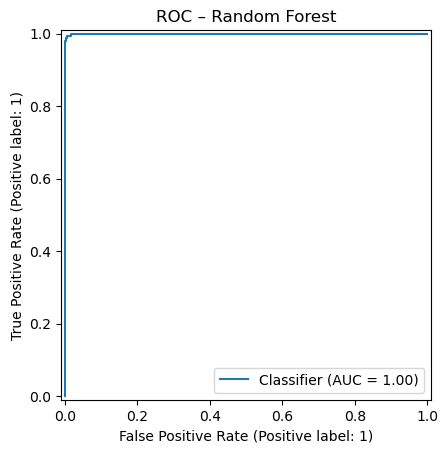

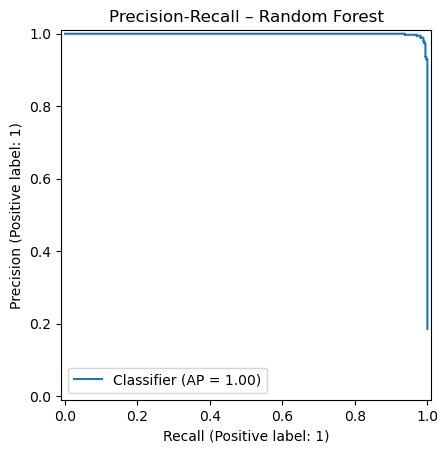

In [ ]:
# # 4.4.2-bis — Courbes ROC & Precision-Recall (visuel)
# from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
# import matplotlib.pyplot as plt

# RocCurveDisplay.from_predictions(y_test, proba_test_rf)
# plt.title("ROC – Random Forest"); plt.show()

# PrecisionRecallDisplay.from_predictions(y_test, proba_test_rf)
# plt.title("Precision-Recall – Random Forest"); plt.show()


#### 4.4.2 Affichage des performances (test)

Nous réutilisons ici les **résultats calculés automatiquement par `eval_model()`** pour la **Random Forest**,  
sans refaire de `fit` ni de prédiction manuelle.

Les principales métriques affichées sont :

- **ROC-AUC** : capacité du modèle à bien classer les défauts et non-défauts  
- **PR-AUC** : précision en fonction du rappel, adaptée aux jeux de données déséquilibrés  
- **Brier score** : mesure la qualité de calibration des probabilités prédites  
- **Matrice de confusion** : erreurs de classification au seuil 0,5  
- **Rapport de classification** : précision, rappel et F1-score par classe

> Cette approche permet de comparer directement les modèles précédents sur des bases identiques.


In [ ]:
# --- 4.4.2 Affichage des performances (test) ---

import numpy as np

print("===== Évaluation Random Forest =====")
print(f"ROC-AUC (test)  : {rf_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test)  : {rf_metrics['pr_auc_test']:.3f}")
print(f"Brier score     : {rf_metrics['brier_test']:.4f}")
print("--------------------------------------------")
print("Matrice de confusion :\n", np.array(rf_metrics["confusion_matrix"]))
print("--------------------------------------------")
print("Rapport de classification :")
print(rf_metrics["classification_report"])


#### 4.4.2-bis Courbes ROC et Precision-Recall

Pour compléter l’évaluation, nous visualisons les courbes :

- **ROC (Receiver Operating Characteristic)** : compare le **taux de vrais positifs** et le **taux de faux positifs**  
- **Precision-Recall** : met en évidence la capacité du modèle à maintenir une bonne précision malgré le déséquilibre des classes

Ces deux graphiques donnent une **lecture visuelle immédiate** de la performance du modèle,  
indépendamment du seuil de décision (0,5 ici).

> Les courbes seront également enregistrées dans **MLflow** afin de pouvoir les consulter directement dans l’interface d’expérimentation.


In [ ]:
# --- 4.4.2-bis Courbes ROC & Precision-Recall (visuel) ---

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np

y_true = np.array(rf_metrics["y_test"])
p_test = np.array(rf_metrics["proba_test"])

RocCurveDisplay.from_predictions(y_true, p_test)
plt.title("ROC – Random Forest")
plt.show()

PrecisionRecallDisplay.from_predictions(y_true, p_test)
plt.title("Precision-Recall – Random Forest")
plt.show()


#### 4.4.3 Interprétation et visualisation de la matrice de confusion

Nous affichons :
- Les **valeurs numériques** (TN, FP, FN, TP) accompagnées de l’**accuracy globale**
- La **heatmap** pour une lecture visuelle plus intuitive

# ---- REDONDANT -- A RETIRER


===== Matrice de confusion – Random Forest =====
Lignes = Valeurs réelles | Colonnes = Prédictions

Vrais négatifs (TN) : 1620
Faux positifs  (FP) : 10
Faux négatifs  (FN) : 3
Vrais positifs  (TP) : 367

Exactitude globale (accuracy) : 99.350%


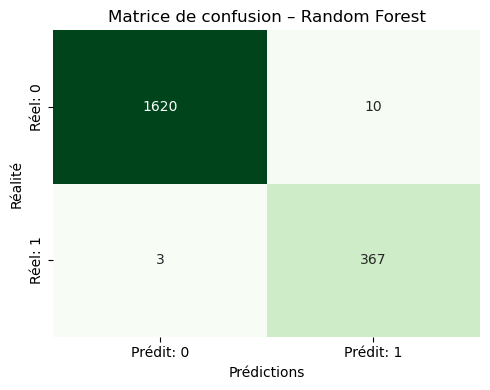

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 📌 Calcul de la matrice de confusion
# cm_rf = confusion_matrix(y_test, preds_rf)

# # ✅ Affichage explicatif ligne par ligne
# print("===== Matrice de confusion – Random Forest =====")
# print("Lignes = Valeurs réelles | Colonnes = Prédictions\n")
# print(f"Vrais négatifs (TN) : {cm_rf[0, 0]}")
# print(f"Faux positifs  (FP) : {cm_rf[0, 1]}")
# print(f"Faux négatifs  (FN) : {cm_rf[1, 0]}")
# print(f"Vrais positifs  (TP) : {cm_rf[1, 1]}")

# # ✅ Calcul de l'exactitude (accuracy)
# accuracy_rf = (cm_rf[0, 0] + cm_rf[1, 1]) / cm_rf.sum()
# print(f"\nExactitude globale (accuracy) : {accuracy_rf:.3%}")

# # ✅ Visualisation : Heatmap de la matrice de confusion
# plt.figure(figsize=(5, 4))
# sns.heatmap(cm_rf,
#             annot=True, fmt="d", cmap="Greens", cbar=False,
#             xticklabels=["Prédit: 0", "Prédit: 1"],
#             yticklabels=["Réel: 0", "Réel: 1"])
# plt.title("Matrice de confusion – Random Forest")
# plt.xlabel("Prédictions")
# plt.ylabel("Réalité")
# plt.tight_layout()
# plt.show()


#### 4.4.3 Interprétation et visualisation de la matrice de confusion

Nous interprétons la **Random Forest** au **seuil 0,5** en **réutilisant la matrice calculée par `eval_model()`**  
(aucun ré-entraînement ni nouvelle prédiction).

- **TN (True Negatives)**, **FP (False Positives)**, **FN (False Negatives)**, **TP (True Positives)**
- **Accuracy** (à interpréter avec prudence en cas de déséquilibre de classes)
- **Heatmap** (carte thermique) pour une lecture visuelle immédiate


In [ ]:
# --- 4.4.3 Interprétation et visualisation de la matrice de confusion ---

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Réutilisation de la matrice fournie par eval_model (aucun fit / aucune prédiction ici)
cm_rf = np.array(rf_metrics["confusion_matrix"])

print("===== Matrice de confusion – Random Forest =====")
print("Lignes = Valeurs réelles | Colonnes = Prédictions\n")

# Décomposition TN/FP/FN/TP
TN, FP, FN, TP = cm_rf[0, 0], cm_rf[0, 1], cm_rf[1, 0], cm_rf[1, 1]
print(f"Vrais négatifs (TN) : {TN}")
print(f"Faux positifs  (FP) : {FP}")
print(f"Faux négatifs  (FN) : {FN}")
print(f"Vrais positifs  (TP) : {TP}")

# Accuracy (info complémentaire ; privilégier AUC/PR-AUC/Recall en dataset déséquilibré)
accuracy_rf = (TP + TN) / cm_rf.sum()
print(f"\nExactitude globale (accuracy) : {accuracy_rf:.3%}")

# Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_rf,
    annot=True, fmt="d", cbar=False,
    cmap="Greens",
    xticklabels=["Prédit: 0", "Prédit: 1"],
    yticklabels=["Réel: 0", "Réel: 1"]
)
plt.title("Matrice de confusion – Random Forest (seuil 0,5)")
plt.xlabel("Prédictions")
plt.ylabel("Réalité")
plt.tight_layout()
plt.show()


### 4.5 Comparaison des modèles

Nous comparons les trois modèles (Régression Logistique, Arbre de Décision, Random Forest)
sur l’échantillon **test** à l’aide des métriques suivantes :

- **ROC-AUC** : capacité de discrimination globale
- **PR-AUC** : adaptée aux classes déséquilibrées
- **Brier score** : qualité de calibration des probabilités (plus **bas** = mieux)
- **Accuracy** (avec seuil 0,5)

Nous classons les modèles par **PR-AUC** puis **ROC-AUC**.

# -- REDONDANT -- A RETIRER 


In [ ]:
# import pandas as pd
# from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, accuracy_score

# def metrics_from_proba(y_true, proba, threshold=0.5, name="model"):
#     preds = (proba >= threshold).astype(int)
#     return {
#         "model": name,
#         "roc_auc": roc_auc_score(y_true, proba),
#         "pr_auc": average_precision_score(y_true, proba),
#         "brier": brier_score_loss(y_true, proba),
#         "accuracy": accuracy_score(y_true, preds)
#     }

# rows = []
# # On suppose que ces variables existent déjà d'après les sections 4.2–4.4 :
# #   proba_test (Logistique), proba_test_tree (Arbre), proba_test_rf (RF)
# rows.append(metrics_from_proba(y_test, proba_test,       name="Logistic Regression"))
# rows.append(metrics_from_proba(y_test, proba_test_tree,  name="Decision Tree"))
# rows.append(metrics_from_proba(y_test, proba_test_rf,    name="Random Forest"))

# df_cmp = pd.DataFrame(rows)
# df_cmp = df_cmp[["model","roc_auc","pr_auc","brier","accuracy"]]
# df_cmp_sorted = df_cmp.sort_values(["pr_auc","roc_auc"], ascending=False).reset_index(drop=True)

# # Affichage propre
# display(df_cmp_sorted.style.format({"roc_auc":"{:.3f}","pr_auc":"{:.3f}","brier":"{:.3f}","accuracy":"{:.3%}"}))

# best_model_name = df_cmp_sorted.loc[0, "model"]
# print(f"\n➡️ Meilleur modèle (par PR-AUC puis ROC-AUC) : **{best_model_name}**")

# # (optionnel) sauvegarde du tableau
# df_cmp_sorted.to_csv("comparaison_modeles.csv", index=False)
# print("✅ Tableau enregistré dans comparaison_modeles.csv (même dossier que le notebook)")



,model,roc_auc,pr_auc,brier,accuracy
0,Logistic Regression,1.000,1.000,0.005,99.550%
1,Random Forest,1.000,0.999,0.006,99.350%
2,Decision Tree,0.997,0.995,0.004,99.550%



➡️ Meilleur modèle (par PR-AUC puis ROC-AUC) : **Logistic Regression**
✅ Tableau enregistré dans comparaison_modeles.csv (même dossier que le notebook)


### 4.5 Comparaison des modèles

Nous comparons les trois modèles sur le jeu **test** à l’aide des métriques suivantes :

- **ROC-AUC** : capacité de discrimination globale  
- **PR-AUC** : précision en fonction du rappel, adaptée aux jeux de données déséquilibrés  
- **Brier score** : qualité de calibration des probabilités (plus il est faible, mieux c’est)  
- **Accuracy** : proportion de bonnes prédictions au seuil 0,5  

Les résultats sont présentés dans un tableau comparatif, trié par **PR-AUC** puis **ROC-AUC**,  
afin d’identifier le **meilleur modèle global**.

> Le tableau est également exporté sous le nom `comparaison_modeles.csv` pour archivage.


In [ ]:
# --- 4.5 Comparaison des modèles ---

import pandas as pd
from sklearn.metrics import accuracy_score

# Fonction pour extraire les principales métriques depuis les résultats eval_model
def summarize_metrics(metrics_dict, name):
    """Extrait les métriques clés du dictionnaire eval_model et calcule l'accuracy."""
    y_true = metrics_dict["y_test"]
    proba = metrics_dict["proba_test"]
    preds = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_true, preds)
    return {
        "model": name,
        "roc_auc": metrics_dict["roc_auc_test"],
        "pr_auc": metrics_dict["pr_auc_test"],
        "brier": metrics_dict["brier_test"],
        "accuracy": acc
    }

# Construction du tableau récapitulatif
rows = [
    summarize_metrics(logreg_metrics, "Logistic Regression"),
    summarize_metrics(tree_metrics, "Decision Tree"),
    summarize_metrics(rf_metrics, "Random Forest")
]

df_cmp = pd.DataFrame(rows)
df_cmp = df_cmp[["model", "roc_auc", "pr_auc", "brier", "accuracy"]]
df_cmp_sorted = df_cmp.sort_values(["pr_auc", "roc_auc"], ascending=False).reset_index(drop=True)

# Affichage du tableau
display(
    df_cmp_sorted.style.format({
        "roc_auc": "{:.3f}",
        "pr_auc": "{:.3f}",
        "brier": "{:.3f}",
        "accuracy": "{:.3%}"
    })
)

# Identification du meilleur modèle
best_model_name = df_cmp_sorted.loc[0, "model"]
print(f"\n➡️ Meilleur modèle (par PR-AUC puis ROC-AUC) : **{best_model_name}**")

# Sauvegarde optionnelle du tableau comparatif
df_cmp_sorted.to_csv("comparaison_modeles.csv", index=False)
print("✅ Tableau enregistré dans comparaison_modeles.csv")


### 4.6 Sauvegarde du modèle final

Une fois le meilleur modèle identifié, nous procédons à :
- La **sauvegarde du pipeline complet** (modèle + prétraitement),
- L’enregistrement du **tableau de comparaison**,
- La sauvegarde des **métriques du meilleur modèle** au format `.json`.

Ces fichiers sont stockés dans le dossier `artifacts/` pour un usage futur (API, dashboard, rapport...).

# -- REDONDANT à RETIRER --



In [ ]:
# from pathlib import Path
# import joblib, json
# from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# # ===============================
# # 4.6 Sauvegarde du meilleur modèle
# # ===============================

# # 1️⃣ Création du dossier 'artifacts' s’il n’existe pas
# ARTIFACTS_DIR = Path("artifacts")
# ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# # 2️⃣ Récupération du meilleur modèle depuis le tableau comparatif
# best_model_name = df_cmp_sorted.loc[0, "model"]
# print(f"➡️ Meilleur modèle sélectionné : \033[1m{best_model_name}\033[0m")

# # 3️⃣ Association avec l’objet pipeline et les probabilités correspondantes
# if best_model_name == "Logistic Regression":
#     best_model = logreg
#     proba_best = proba_test
# elif best_model_name == "Decision Tree":
#     best_model = tree
#     proba_best = proba_test_tree
# elif best_model_name == "Random Forest":
#     best_model = rf
#     proba_best = proba_test_rf
# else:
#     raise ValueError("❌ Modèle non reconnu dans la sélection.")

# # 4️⃣ Sauvegarde du modèle (pipeline complet)
# model_filename = best_model_name.replace(" ", "_").lower() + "_final.joblib"
# model_path = ARTIFACTS_DIR / model_filename
# joblib.dump(best_model, model_path)
# print(f"✅ Modèle sauvegardé dans : \033[94m{model_path}\033[0m")

# # 5️⃣ Sauvegarde du tableau comparatif des modèles
# cmp_path = ARTIFACTS_DIR / "comparaison_modeles.csv"
# df_cmp_sorted.to_csv(cmp_path, index=False)
# print(f"✅ Tableau comparatif enregistré dans : \033[94m{cmp_path}\033[0m")

# # 6️⃣ Sauvegarde des métriques du meilleur modèle (JSON)
# metrics = {
#     "model": best_model_name,
#     "roc_auc": float(roc_auc_score(y_test, proba_best)),
#     "pr_auc": float(average_precision_score(y_test, proba_best)),
#     "brier": float(brier_score_loss(y_test, proba_best)),
#     "accuracy": float(((proba_best >= 0.5).astype(int) == y_test).mean())
# }

# metrics_path = ARTIFACTS_DIR / "best_model_metrics.json"
# with open(metrics_path, "w") as f:
#     json.dump(metrics, f, indent=2)

# print(f"✅ Métriques du modèle enregistrées dans : \033[94m{metrics_path}\033[0m")

# # 7️⃣ Affichage du contenu du dossier artifacts
# print("\n📂 Contenu du dossier 'artifacts' :")
# for p in ARTIFACTS_DIR.iterdir():
#     print(" -", p.name)


➡️ Meilleur modèle sélectionné : Logistic Regression
✅ Modèle sauvegardé dans : artifacts\logistic_regression_final.joblib
✅ Tableau comparatif enregistré dans : artifacts\comparaison_modeles.csv
✅ Métriques du modèle enregistrées dans : artifacts\best_model_metrics.json

📂 Contenu du dossier 'artifacts' :
 - best_model_metrics.json
 - comparaison_modeles.csv
 - logistic_regression_final.joblib
 - sklearn_version.txt


### 4.6 Sauvegarde du modèle final et des artefacts

Une fois le meilleur modèle identifié, nous procédons à la **sauvegarde complète** pour utilisation ultérieure.

Les fichiers suivants sont générés dans le dossier `artifacts/` :

- Le **pipeline complet** (prétraitement + modèle entraîné) au format `.joblib`
- Le **tableau comparatif** des performances des modèles (`comparaison_modeles.csv`)
- Les **métriques du meilleur modèle** au format `.json`

> Ces fichiers seront utilisés dans la suite du projet pour le **déploiement du modèle** (API Streamlit et suivi MLflow).


In [ ]:
# --- 4.6 Sauvegarde du meilleur modèle et des artefacts ---

from pathlib import Path
import joblib, json
from sklearn.metrics import accuracy_score

# 1️⃣ Création (ou vérification) du dossier 'artifacts'
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# 2️⃣ Récupération du meilleur modèle à partir du tableau comparatif
best_model_name = df_cmp_sorted.loc[0, "model"]
print(f"➡️ Meilleur modèle sélectionné : {best_model_name}")

# 3️⃣ Association au bon objet et aux métriques correspondantes
if best_model_name == "Logistic Regression":
    best_model = logreg
    best_metrics = logreg_metrics
elif best_model_name == "Decision Tree":
    best_model = tree
    best_metrics = tree_metrics
elif best_model_name == "Random Forest":
    best_model = rf
    best_metrics = rf_metrics
else:
    raise ValueError("❌ Modèle non reconnu parmi les résultats comparés.")

# 4️⃣ Sauvegarde du pipeline complet (prétraitement + modèle)
model_filename = best_model_name.replace(" ", "_").lower() + "_final.joblib"
model_path = ARTIFACTS_DIR / model_filename
joblib.dump(best_model, model_path)
print(f"✅ Modèle sauvegardé dans : {model_path}")

# 5️⃣ Sauvegarde du tableau comparatif
cmp_path = ARTIFACTS_DIR / "comparaison_modeles.csv"
df_cmp_sorted.to_csv(cmp_path, index=False)
print(f"✅ Tableau comparatif enregistré dans : {cmp_path}")

# 6️⃣ Sauvegarde des métriques du meilleur modèle au format JSON
y_true = best_metrics["y_test"]
proba = best_metrics["proba_test"]
preds = (proba >= 0.5).astype(int)

metrics = {
    "model": best_model_name,
    "roc_auc": float(best_metrics["roc_auc_test"]),
    "pr_auc": float(best_metrics["pr_auc_test"]),
    "brier": float(best_metrics["brier_test"]),
    "accuracy": float(accuracy_score(y_true, preds))
}

metrics_path = ARTIFACTS_DIR / "best_model_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Métriques enregistrées dans : {metrics_path}")

# 7️⃣ Vérification du contenu du dossier artifacts
print("\n📂 Contenu actuel du dossier 'artifacts' :")
for p in ARTIFACTS_DIR.iterdir():
    print(" -", p.name)


### debut mlflow 

## 5. Tracking des expériences avec MLflow

Dans cette section, nous mettons en place **MLflow** pour tracer toutes les expériences de modélisation, garantir la **reproductibilité** et préparer le **déploiement**.

### Objectifs
- Centraliser les **runs** (itérations) par **expérience** (*un modèle = un experiment*).
- Logger les **hyperparamètres** (params), les **métriques** clés (**ROC-AUC**, **PR-AUC**, **Brier**, **Accuracy**) et les **artifacts** (ROC, PR, matrice de confusion).
- Enregistrer le **pipeline complet** (*prétraitement + modèle*) avec **signature** et **input_example**.
- Assurer la **traçabilité du dataset** (chemin + **empreinte SHA-256**) et la graine de split.

### Convention de nommage
- **Experiments** : `logistic_regression`, `decision_tree`, `random_forest`.
- **Runs** : une configuration d’hyperparamètres = **un run** (ex. `C=2.0_pen=l2_solver=lbfgs_seed42`).

### Lancer l’UI MLflow (local)
```bash
mlflow ui --port 5000


### 5.1  Initialisation de MLflow & traçabilité du dataset

- **`mlflow.set_tracking_uri("file:./mlruns")`** : stocke tous les runs localement dans le dossier `./mlruns`.
- **Pourquoi tracer le dataset ?** Pour que chaque run conserve la référence exacte des données utilisées (chemin + empreinte SHA-256).  
  Cela prouve la **reproductibilité** : même si le fichier change plus tard, on sait quelle version a servi.

**Ce que fait le code ci-dessous :**
1. Importe MLflow.
2. Fixe le dossier de tracking (`./mlruns`).
3. Définit le chemin vers le CSV (`DATA_PATH`).
4. Calcule le hash SHA-256 du fichier (`DATA_SHA`) pour l’enregistrer ensuite comme **tag** dans chaque run.

# --- REDONDANT -- A RETIRER


In [ ]:
# # (facultatif dans un notebook; évite en prod/CI) 
# # !pip install -q mlflow==2.16.0

# import os
# import hashlib
# from pathlib import Path
# import mlflow, mlflow.sklearn

# # 1) Fixe l’unique URI de tracking (une seule fois, tout en haut des blocs MLflow)
# mlflow.set_tracking_uri("file:./mlruns")  # dossier local ./mlruns

# # 2) Traçabilité du dataset (path + hash)
# DATA_PATH = Path("Data/Loan_Data.csv")
# if not DATA_PATH.exists():
#     raise FileNotFoundError(f"Dataset introuvable: {DATA_PATH.resolve()}")

# def sha256(file_path: Path, chunk_size: int = 1024 * 1024) -> str:
#     h = hashlib.sha256()
#     with open(file_path, "rb") as f:
#         for chunk in iter(lambda: f.read(chunk_size), b""):
#             h.update(chunk)
#     return h.hexdigest()

# DATA_SHA = sha256(DATA_PATH)


### 5.1 Initialisation de MLflow et traçabilité du dataset

Avant de lancer les expériences de modélisation, nous configurons **MLflow** pour :

- Stocker tous les runs localement (`./mlruns`)
- Garantir la **traçabilité des données** utilisées pour l’entraînement :
  - Chemin exact du dataset
  - Empreinte **SHA-256** (unique et infalsifiable)

Cette empreinte permettra de vérifier que chaque modèle a bien été entraîné
sur la même version du dataset, assurant ainsi une **reproductibilité totale**.

> L’empreinte est enregistrée comme **tag MLflow** dans chaque run.


In [ ]:
# --- 5.1 Initialisation de MLflow & traçabilité du dataset ---

import os
import hashlib
from pathlib import Path
import mlflow
import mlflow.sklearn

# 1️⃣ Définition du dossier local de tracking
# Tous les runs seront enregistrés dans ./mlruns
mlflow.set_tracking_uri("file:./mlruns")

# 2️⃣ Définition du chemin du dataset utilisé pour l'entraînement
DATA_PATH = Path("Data/Loan_Data.csv")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"❌ Dataset introuvable : {DATA_PATH.resolve()}")

# 3️⃣ Fonction pour calculer l’empreinte SHA-256 du dataset
# Cela garantit la reproductibilité complète des expériences
def compute_sha256(file_path: Path, chunk_size: int = 1024 * 1024) -> str:
    """Calcule le hash SHA-256 d’un fichier pour traçabilité."""
    h = hashlib.sha256()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# 4️⃣ Calcul du hash pour le dataset courant
DATA_SHA = compute_sha256(DATA_PATH)

print("✅ Tracking MLflow initialisé")
print(f"📁 Dossier de tracking : ./mlruns")
print(f"📊 Dataset utilisé : {DATA_PATH}")
print(f"🔒 Empreinte SHA-256 : {DATA_SHA[:32]}...")  # affichage abrégé


### 5.2 Fonction utilitaire : `run_with_mlflow(...)`

**But.** Lancer une itération d’entraînement (**run**) pour un **experiment** donné et journaliser automatiquement l’essentiel dans **MLflow**.

**Conformité.**
- *Un modèle = un experiment* (`mlflow.set_experiment(...)`)
- *Une itération = un run* (`mlflow.start_run(...)`)

**Contenu loggé.**
- **Tags** : `dataset_path`, `dataset_sha256`, `split_seed`
- **Params** : hyperparamètres + `threshold` (+ liste `features` si dispo)
- **Metrics** : `roc_auc`, `pr_auc`, `brier`, `accuracy`
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png`
- **Model** : pipeline **sklearn** (préproc + estimateur) avec **signature** et **input_example**

> Résultat : l’UI MLflow montre pour chaque **experiment** plusieurs **runs** avec leurs **params**, **métriques**, **figures** et le **modèle** (artifact `model/`). Parfait pour les captures demandées en soutenance.

# --- REDONDANT -- A RETIRER



In [ ]:
# from pathlib import Path
# import numpy as np, matplotlib.pyplot as plt
# from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
#                              confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
# from mlflow.models import infer_signature  # <-- pour signature
# import mlflow

# def run_with_mlflow(experiment_name, run_name, pipeline, X_train, y_train, X_test, y_test, params):
#     # 1 modèle = 1 experiment
#     mlflow.set_experiment(experiment_name)
#     with mlflow.start_run(run_name=run_name):  # 1 itération = 1 run
#         # --- Tags utiles (traçabilité) ---
#         mlflow.set_tags({
#             "dataset_path": DATA_PATH,
#             "dataset_sha256": DATA_SHA,
#             "split_seed": 42
#         })

#         # --- Hyperparamètres + (optionnel) liste des features ---
#         mlflow.log_params(params)
#         try:
#             mlflow.log_param("features", ",".join(list(X_train.columns)))
#         except Exception:
#             pass  # au cas où X_train n'est pas un DataFrame

#         # --- Entraînement ---
#         pipeline.fit(X_train, y_train)
#         proba = pipeline.predict_proba(X_test)[:, 1]
#         preds = (proba >= 0.5).astype(int)

#         # --- Métriques principales ---
#         mlflow.log_metrics({
#             "roc_auc": roc_auc_score(y_test, proba),
#             "pr_auc":  average_precision_score(y_test, proba),
#             "brier":   brier_score_loss(y_test, proba),
#             "accuracy": float((preds == y_test).mean())
#         })

#         # --- Artifacts (courbes) ---
#         RocCurveDisplay.from_predictions(y_test, proba); plt.title("ROC"); plt.tight_layout()
#         plt.savefig("roc_curve.png", dpi=120); plt.close()
#         PrecisionRecallDisplay.from_predictions(y_test, proba); plt.title("PR"); plt.tight_layout()
#         plt.savefig("pr_curve.png", dpi=120); plt.close()
#         cm = confusion_matrix(y_test, preds)
#         plt.imshow(cm); plt.title("Confusion"); plt.xlabel("Pred"); plt.ylabel("True")
#         for (i, j), v in np.ndenumerate(cm):
#             plt.text(j, i, str(v), ha="center", va="center")
#         plt.tight_layout(); plt.savefig("confusion_matrix.png", dpi=120); plt.close()
#         mlflow.log_artifact("roc_curve.png")
#         mlflow.log_artifact("pr_curve.png")
#         mlflow.log_artifact("confusion_matrix.png")

#         # --- Log du modèle (sans warning) : name + signature + input_example ---
#         try:
#             input_example = X_test.iloc[:5].copy()   # petit batch d'exemple
#         except Exception:
#             # si X_test n'est pas un DataFrame
#             import pandas as pd
#             input_example = pd.DataFrame(X_test[:5])

#         proba_example = pipeline.predict_proba(input_example)[:, 1]
#         signature = infer_signature(input_example, proba_example)

#         mlflow.sklearn.log_model(
#             sk_model=pipeline,
#             name="model",                     # <-- remplace artifact_path déprécié
#             signature=signature,
#             input_example=input_example
#         )

#         return {"roc_auc": roc_auc_score(y_test, proba),
#                 "pr_auc":  average_precision_score(y_test, proba),
#                 "brier":   brier_score_loss(y_test, proba),
#                 "accuracy": float((preds == y_test).mean())}


In [ ]:
# from pathlib import Path
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import (
#     roc_auc_score, average_precision_score, brier_score_loss,
#     confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
# )
# from mlflow.models import infer_signature
# import mlflow

# def run_with_mlflow(
#     experiment_name: str,
#     run_name: str,
#     pipeline,                 # Pipeline sklearn: (preproc -> estimator)
#     X_train, y_train,
#     X_test, y_test,
#     params: dict,             # Hyperparamètres du modèle
#     threshold: float = 0.5    # Seuil de décision pour la classe positive
# ):
#     """
#     Lance une itération d'entraînement (run) pour un experiment MLflow donné,
#     et logge automatiquement tags, params, métriques, figures et modèle.

#     Retourne: dict(métriques principales)
#     """
#     # 1) Un modèle = un experiment
#     mlflow.set_experiment(experiment_name)

#     # 2) Une itération = un run
#     with mlflow.start_run(run_name=run_name):

#         # --- Tags de traçabilité (dataset + seed) ---
#         mlflow.set_tags({
#             "dataset_path": str(DATA_PATH),   # ex: Data/Loan_Data.csv
#             "dataset_sha256": DATA_SHA,       # empreinte pour la reproductibilité
#             "split_seed": 42
#         })

#         # --- Hyperparamètres + (optionnel) liste des features ---
#         mlflow.log_params(params)
#         mlflow.log_param("threshold", threshold)
#         try:
#             mlflow.log_param("features", ",".join(list(X_train.columns)))
#         except Exception:
#             pass  # si X_train n'est pas un DataFrame (numpy array)

#         # --- Entraînement + prédictions ---
#         pipeline.fit(X_train, y_train)
#         proba = pipeline.predict_proba(X_test)[:, 1]
#         preds = (proba >= threshold).astype(int)

#         # --- Métriques principales ---
#         metrics = {
#             "roc_auc": roc_auc_score(y_test, proba),
#             "pr_auc":  average_precision_score(y_test, proba),
#             "brier":   brier_score_loss(y_test, proba),
#             "accuracy": float((preds == y_test).mean())
#         }
#         mlflow.log_metrics(metrics)

#         # --- Figures (loguées proprement via MLflow) ---
#         fig = plt.figure()
#         RocCurveDisplay.from_predictions(y_test, proba)
#         plt.title("ROC"); plt.tight_layout()
#         mlflow.log_figure(fig, "roc_curve.png"); plt.close(fig)

#         fig = plt.figure()
#         PrecisionRecallDisplay.from_predictions(y_test, proba)
#         plt.title("Precision-Recall"); plt.tight_layout()
#         mlflow.log_figure(fig, "pr_curve.png"); plt.close(fig)

#         cm = confusion_matrix(y_test, preds)
#         fig = plt.figure()
#         plt.imshow(cm)
#         plt.title("Confusion Matrix"); plt.xlabel("Pred"); plt.ylabel("True")
#         for (i, j), v in np.ndenumerate(cm):
#             plt.text(j, i, str(v), ha="center", va="center")
#         plt.tight_layout()
#         mlflow.log_figure(fig, "confusion_matrix.png"); plt.close(fig)

#         # --- Log du modèle (pipeline complet: préproc + estimateur) ---
#         # input_example casté en float64 pour éviter le warning de schéma
#         try:
#             input_example = X_test.iloc[:5].copy()
#         except Exception:
#             import pandas as pd
#             input_example = pd.DataFrame(X_test[:5])
#         try:
#             input_example = input_example.astype("float64")
#         except Exception:
#             pass

#         proba_example = pipeline.predict_proba(input_example)[:, 1]
#         signature = infer_signature(input_example, proba_example)

#         mlflow.sklearn.log_model(
#             sk_model=pipeline,
#             artifact_path="model",   # MLflow 2.x
#             signature=signature,
#             input_example=input_example
#         )

#         return metrics


### 5.2 Fonction utilitaire : `run_with_mlflow(...)`

Cette fonction centralise toute la logique d’un **run MLflow** :

- **Un modèle = un experiment**
- **Une configuration d’hyperparamètres = un run**

Elle gère automatiquement :
- Les **tags** (traçabilité du dataset et graine aléatoire),
- Les **params** (hyperparamètres et seuil),
- Les **metrics** principales (`ROC-AUC`, `PR-AUC`, `Brier`, `Accuracy`),
- Les **figures** (`ROC`, `Precision-Recall`, `Confusion Matrix`),
- Et le **modèle complet** (pipeline sklearn + signature + input_example).

> Cette fonction sera appelée plusieurs fois (une par modèle) pour logger
> la **régression logistique**, l’**arbre de décision** et la **forêt aléatoire** dans MLflow.


In [ ]:
# --- 5.2 Fonction utilitaire : run_with_mlflow(...) ---

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from mlflow.models import infer_signature
import mlflow

def run_with_mlflow(
    experiment_name: str,
    run_name: str,
    pipeline,                 # Pipeline sklearn (préproc + estimateur)
    X_train, y_train,
    X_test, y_test,
    params: dict,             # Hyperparamètres à logger
    threshold: float = 0.5    # Seuil de décision pour la classe positive
):
    """
    Lance un run MLflow pour un modèle donné.
    Log automatiquement : tags, hyperparamètres, métriques, figures et pipeline complet.

    Parameters
    ----------
    experiment_name : str
        Nom de l’expérience (ex: "logistic_regression")
    run_name : str
        Nom du run (ex: "C=1.0_pen=l2_seed42")
    pipeline : sklearn.Pipeline
        Contient prétraitement + modèle
    X_train, y_train, X_test, y_test : array ou DataFrame
        Jeux d’entraînement et de test
    params : dict
        Dictionnaire d’hyperparamètres
    threshold : float
        Seuil de décision pour classer les probabilités
    """

    # 1️⃣ Crée (ou réutilise) l’expérience correspondante
    mlflow.set_experiment(experiment_name)

    # 2️⃣ Démarre un run MLflow
    with mlflow.start_run(run_name=run_name):

        # --- TAGS : infos générales et reproductibilité ---
        mlflow.set_tags({
            "dataset_path": str(DATA_PATH),
            "dataset_sha256": DATA_SHA,
            "split_seed": 42
        })

        # --- PARAMS : hyperparamètres et seuil ---
        mlflow.log_params(params)
        mlflow.log_param("threshold", threshold)

        # Ajout (facultatif) de la liste des features
        if hasattr(X_train, "columns"):
            mlflow.log_param("features", ",".join(X_train.columns))

        # --- ENTRAÎNEMENT ---
        pipeline.fit(X_train, y_train)
        proba = pipeline.predict_proba(X_test)[:, 1]
        preds = (proba >= threshold).astype(int)

        # --- MÉTRIQUES ---
        metrics = {
            "roc_auc": roc_auc_score(y_test, proba),
            "pr_auc": average_precision_score(y_test, proba),
            "brier": brier_score_loss(y_test, proba),
            "accuracy": float((preds == y_test).mean())
        }
        mlflow.log_metrics(metrics)

        # --- FIGURES ---
        # ROC
        fig = plt.figure()
        RocCurveDisplay.from_predictions(y_test, proba)
        plt.title("ROC Curve"); plt.tight_layout()
        mlflow.log_figure(fig, "roc_curve.png")
        plt.close(fig)

        # Precision-Recall
        fig = plt.figure()
        PrecisionRecallDisplay.from_predictions(y_test, proba)
        plt.title("Precision-Recall Curve"); plt.tight_layout()
        mlflow.log_figure(fig, "pr_curve.png")
        plt.close(fig)

        # Confusion Matrix
        cm = confusion_matrix(y_test, preds)
        fig = plt.figure()
        plt.imshow(cm, cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("True")
        for (i, j), v in np.ndenumerate(cm):
            plt.text(j, i, str(v), ha="center", va="center")
        plt.tight_layout()
        mlflow.log_figure(fig, "confusion_matrix.png")
        plt.close(fig)

        # --- MODÈLE (pipeline complet) ---
        # Input example (5 premières lignes)
        try:
            input_example = X_test.iloc[:5].astype("float64")
        except Exception:
            import pandas as pd
            input_example = pd.DataFrame(X_test[:5]).astype("float64")

        # Signature (schéma d’entrée/sortie)
        proba_example = pipeline.predict_proba(input_example)[:, 1]
        signature = infer_signature(input_example, proba_example)

        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path="model",
            signature=signature,
            input_example=input_example
        )

        print(f"✅ Run MLflow terminé : {experiment_name}/{run_name}")
        print("📊 Métriques :", {k: round(v, 3) for k, v in metrics.items()})
        return metrics


### 5.3 Expérience : `logistic_regression` — itérations (runs)

**Objectif.** Appliquer la règle *un modèle = un experiment* ; ici l’algorithme est **Logistic Regression**.

**Runs testés.**
- Run 1 : configuration baseline (`C=1.0`, `penalty=l2`, `solver=lbfgs`)
- Run 2 : variation d’hyperparamètre (`C=2.0`)

**Traçabilité.**
- **Params** loggés : `C`, `penalty`, `solver`, `max_iter`, `class_weight`, `random_state` (+ `threshold`).
- **Metrics** : `roc_auc`, `pr_auc`, `brier`, `accuracy` (loggées automatiquement par `run_with_mlflow`).
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png` (dans chaque run).
- **Model** : pipeline sklearn complet (préproc + estimateur) loggé avec signature + input_example.

**À montrer dans MLflow.**
- Dans l’experiment **`logistic_regression`**, afficher les colonnes `roc_auc`, `pr_auc`, `accuracy`, `brier`.
- Vérifier la présence de **plusieurs runs** (itérations) et ouvrir les artifacts (ROC/PR/Confusion).

# -- REDONDANT -- A RETIRER



2025/10/15 14:31:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/10/15 14:31:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


{'roc_auc': 0.9999867352014592,
 'pr_auc': 0.9999423019394917,
 'brier': 0.0034291380862933136,
 'accuracy': 0.997}

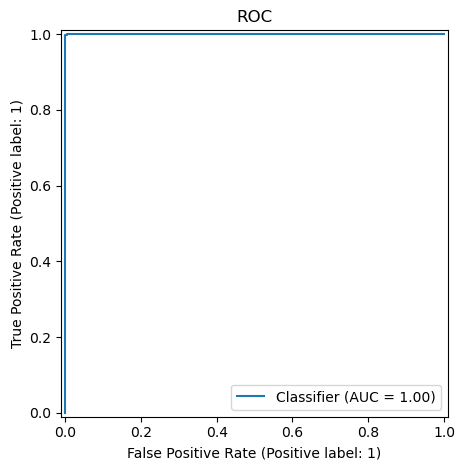

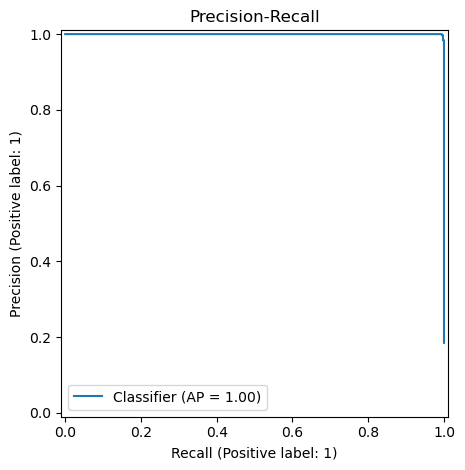

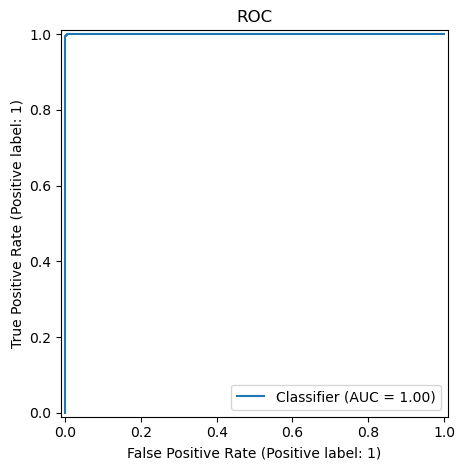

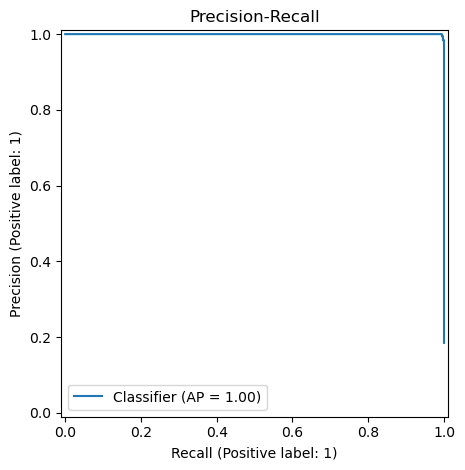

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression

# # -----------------------------
# # Run 1 : baseline (C = 1.0)
# # -----------------------------
# # Pipeline = prétraitement (imputer + scaler) + régression logistique
# logreg = Pipeline(steps=[
#     ("preproc", preproc),
#     ("clf", LogisticRegression(
#         C=1.0,                 # intensité de la régularisation (1/λ). Plus C est grand, moins on régularise.
#         penalty="l2",          # pénalité L2 (Ridge) classique pour la logreg
#         solver="lbfgs",        # solveur robuste pour L2
#         max_iter=2000,         # itérations suffisantes pour garantir la convergence
#         class_weight="balanced",   # gère le déséquilibre de classes
#         random_state=42        # reproductibilité
#     ))
# ])

# # Exécute un run MLflow : log des params/métriques/figures/modèle
# run_with_mlflow(
#     experiment_name="logistic_regression",                # 1 modèle = 1 experiment
#     run_name="C=1.0_pen=l2_solver=lbfgs_seed42",          # nom lisible dans l’UI
#     pipeline=logreg,
#     X_train=X_train, y_train=y_train,
#     X_test=X_test, y_test=y_test,
#     params={                                              # hyperparams loggés dans MLflow
#         "model": "logreg",
#         "C": 1.0, "penalty": "l2", "solver": "lbfgs",
#         "max_iter": 2000, "class_weight": "balanced", "random_state": 42
#     }
#     # threshold=0.5  # (optionnel) le seuil est déjà 0.5 par défaut dans run_with_mlflow
# )

# # -----------------------------
# # Run 2 : variation (C = 2.0)
# # -----------------------------
# logreg2 = Pipeline(steps=[
#     ("preproc", preproc),
#     ("clf", LogisticRegression(
#         C=2.0,                 # régularisation un peu plus faible (C plus grand)
#         penalty="l2",
#         solver="lbfgs",
#         max_iter=2000,
#         class_weight="balanced",
#         random_state=42
#     ))
# ])

# run_with_mlflow(
#     experiment_name="logistic_regression",
#     run_name="C=2.0_pen=l2_solver=lbfgs_seed42",
#     pipeline=logreg2,
#     X_train=X_train, y_train=y_train,
#     X_test=X_test, y_test=y_test,
#     params={
#         "model": "logreg",
#         "C": 2.0, "penalty": "l2", "solver": "lbfgs",
#         "max_iter": 2000, "class_weight": "balanced", "random_state": 42
#     }
# )


In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression

# # -----------------------------
# # Run 1 : baseline (C = 1.0)
# # -----------------------------
# # Pipeline = prétraitement (imputer + scaler) + régression logistique
# logreg = Pipeline(steps=[
#     ("preproc", preproc),
#     ("clf", LogisticRegression(
#         C=1.0,                 # intensité de la régularisation (1/λ). Plus C est grand, moins on régularise.
#         penalty="l2",          # pénalité L2 (Ridge) classique pour la logreg
#         solver="lbfgs",        # solveur robuste pour L2
#         max_iter=2000,         # itérations suffisantes pour garantir la convergence
#         class_weight="balanced",   # gère le déséquilibre de classes
#         random_state=42        # reproductibilité
#     ))
# ])

# # Exécute un run MLflow : log des params/métriques/figures/modèle
# run_with_mlflow(
#     experiment_name="logistic_regression",                # 1 modèle = 1 experiment
#     run_name="C=1.0_pen=l2_solver=lbfgs_seed42",          # nom lisible dans l’UI
#     pipeline=logreg,
#     X_train=X_train, y_train=y_train,
#     X_test=X_test, y_test=y_test,
#     params={                                              # hyperparams loggés dans MLflow
#         "model": "logreg",
#         "C": 1.0, "penalty": "l2", "solver": "lbfgs",
#         "max_iter": 2000, "class_weight": "balanced", "random_state": 42
#     }
#     # threshold=0.5  # (optionnel) le seuil est déjà 0.5 par défaut dans run_with_mlflow
# )

# # -----------------------------
# # Run 2 : variation (C = 2.0)
# # -----------------------------
# logreg2 = Pipeline(steps=[
#     ("preproc", preproc),
#     ("clf", LogisticRegression(
#         C=2.0,                 # régularisation un peu plus faible (C plus grand)
#         penalty="l2",
#         solver="lbfgs",
#         max_iter=2000,
#         class_weight="balanced",
#         random_state=42
#     ))
# ])

# run_with_mlflow(
#     experiment_name="logistic_regression",
#     run_name="C=2.0_pen=l2_solver=lbfgs_seed42",
#     pipeline=logreg2,
#     X_train=X_train, y_train=y_train,
#     X_test=X_test, y_test=y_test,
#     params={
#         "model": "logreg",
#         "C": 2.0, "penalty": "l2", "solver": "lbfgs",
#         "max_iter": 2000, "class_weight": "balanced", "random_state": 42
#     }
# )


2025/10/17 11:16:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Metrics (LogReg C=1.0) : {'roc_auc': 0.9999883933012768, 'pr_auc': 0.9999495671634833, 'brier': 0.004650069542532288, 'accuracy': 0.9955}


2025/10/17 11:16:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Metrics (LogReg C=2.0): {'roc_auc': 0.9999867352014592, 'pr_auc': 0.9999423019394917, 'brier': 0.0034291380862933136, 'accuracy': 0.997}


### 5.3 Expérience : `logistic_regression` — itérations (runs)

#### 🎯 Objectif
Appliquer la règle *un modèle = un experiment* ; ici, nous testons l’algorithme **Logistic Regression**.

#### 🧠 Runs testés
- **Run 1** : configuration baseline (`C=1.0`, `penalty=l2`, `solver=lbfgs`)  
- **Run 2** : variation d’hyperparamètre (`C=2.0`)

#### 📊 Informations loggées
- **Params** : `C`, `penalty`, `solver`, `max_iter`, `class_weight`, `random_state`, `threshold`
- **Metrics** : `roc_auc`, `pr_auc`, `brier`, `accuracy`
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png`
- **Model** : pipeline sklearn complet (prétraitement + estimateur) avec *signature* et *input_example*

#### 🧩 Résultat attendu dans MLflow
- Experiment : **`logistic_regression`**
- Plusieurs **runs** visibles avec leurs paramètres et métriques
- Artifacts (ROC, PR, matrice de confusion) disponibles dans chaque run


In [ ]:
# --- 5.3 Expérience : logistic_regression — runs MLflow ---

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# ==========================================
# 🧩 Run 1 : Configuration de base (C = 1.0)
# ==========================================
logreg = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", LogisticRegression(
        C=1.0,                   # Intensité de la régularisation (1/λ)
        penalty="l2",            # Régularisation L2 (classique)
        solver="lbfgs",          # Solveur stable pour L2
        max_iter=2000,           # Itérations suffisantes
        class_weight="balanced", # Gère le déséquilibre de classes
        random_state=42          # Reproductibilité
    ))
])

# ▶ Lancement du run MLflow (baseline)
run_with_mlflow(
    experiment_name="logistic_regression",      # Un modèle = un experiment
    run_name="C=1.0_pen=l2_solver=lbfgs_seed42",# Nom lisible dans l’UI MLflow
    pipeline=logreg,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    params={                                   # Hyperparamètres loggés
        "model": "logistic_regression",
        "C": 1.0,
        "penalty": "l2",
        "solver": "lbfgs",
        "max_iter": 2000,
        "class_weight": "balanced",
        "random_state": 42
    }
)

# ==========================================
# 🧩 Run 2 : Variation (C = 2.0)
# ==========================================
logreg_var = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", LogisticRegression(
        C=2.0,                   # Régularisation plus faible (plus flexible)
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

# ▶ Lancement du deuxième run MLflow (variation d’hyperparamètre)
run_with_mlflow(
    experiment_name="logistic_regression",
    run_name="C=2.0_pen=l2_solver=lbfgs_seed42",
    pipeline=logreg_var,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    params={
        "model": "logistic_regression",
        "C": 2.0,
        "penalty": "l2",
        "solver": "lbfgs",
        "max_iter": 2000,
        "class_weight": "balanced",
        "random_state": 42
    }
)


### 5.4 Experiment : `decision_tree` — itérations (runs par profondeur)

- **Objectif** : évaluer un **Arbre de Décision** à différentes profondeurs tout en respectant
  la règle *Un modèle = un experiment* / *Une itération = un run*.
- **Runs générés** : `criterion=gini_depth=4_leaf=1`, `...=6_leaf=1`, `...=8_leaf=1`.
- **Traçabilité (params)** : `criterion`, `max_depth`, `min_samples_leaf`, `class_weight`, `random_state`.
- **Métriques loggées** : `roc_auc`, `pr_auc`, `brier`, `accuracy`.
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png`.
- **Ce que montrer dans MLflow** :
  - Ouvrir l’experiment **`decision_tree`**, afficher les colonnes `roc_auc`, `pr_auc`, `accuracy`, `brier`,
    et montrer plusieurs **runs** (itérations) dans la table.
# REDONDANT A RETIRER


In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline

# # 3 itérations = 3 runs (profondeurs différentes)
# for depth in [4, 6, 8]:
#     tree = Pipeline(steps=[
#         ("preproc", preproc),
#         ("clf", DecisionTreeClassifier(
#             criterion="gini",          # expliciter pour la traçabilité
#             max_depth=depth,
#             min_samples_leaf=1,        # expliciter la valeur par défaut
#             class_weight="balanced",
#             random_state=42
#         ))
#     ])

#     run_with_mlflow(
#         experiment_name="decision_tree",                 # 👉 1 modèle = 1 experiment
#         run_name=f"criterion=gini_depth={depth}_leaf=1_seed42",  # 👉 1 itération = 1 run
#         pipeline=tree,
#         X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
#         params={
#             "model": "decision_tree",
#             "criterion": "gini",
#             "max_depth": depth,
#             "min_samples_leaf": 1,
#             "class_weight": "balanced",
#             "random_state": 42
#         }
#     )


c:\Users\User\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



c:\Users\User\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



c:\Users\User\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



2025/10/15 14:39:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/10/15 14:39:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/10/15 14:39:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


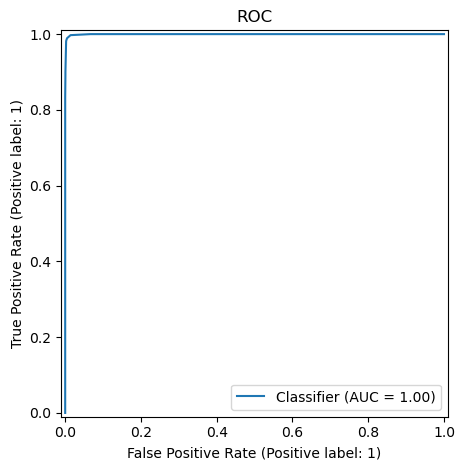

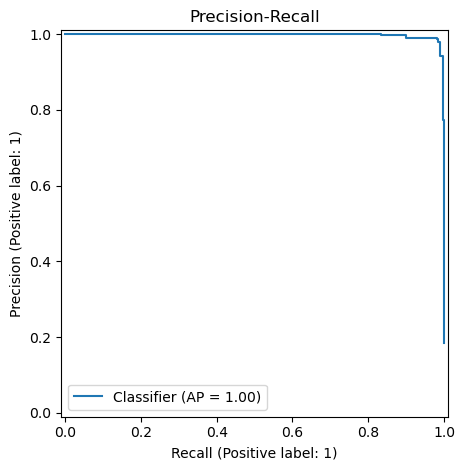

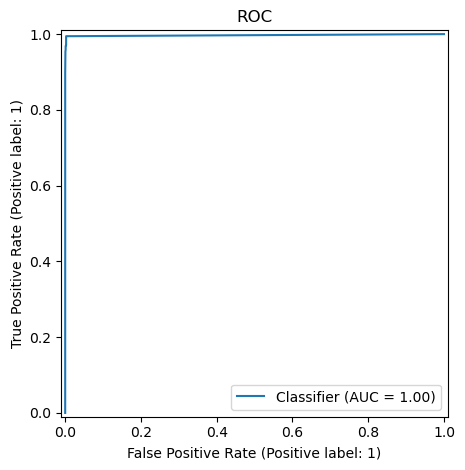

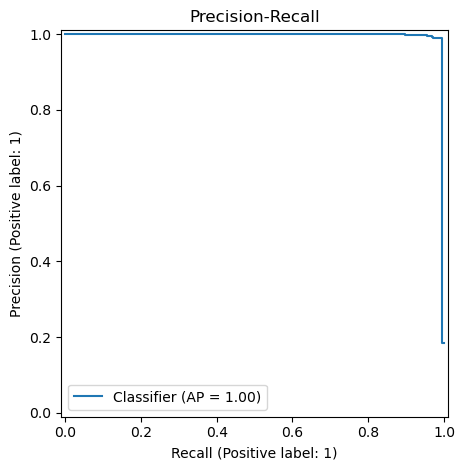

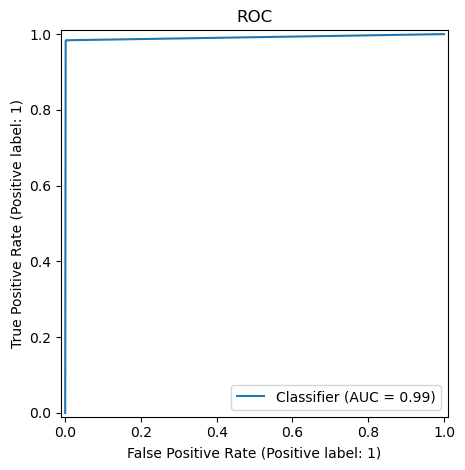

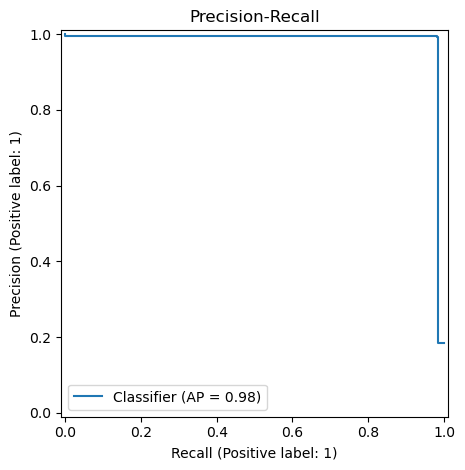

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline

# # Nous allons lancer 3 runs MLflow pour le même modèle (Decision Tree)
# # en faisant varier uniquement la profondeur max de l'arbre (4, 6, 8).
# for depth in [4, 6, 8]:

#     # 1) Construire un pipeline = prétraitement + modèle
#     # - preproc : ton ColumnTransformer (imputation médiane + StandardScaler)
#     # - clf     : l'Arbre de Décision avec les hyperparamètres que l'on veut tracer
#     tree = Pipeline(steps=[
#         ("preproc", preproc),  # >>> évite les fuites : le prétraitement est appris dans le pipeline
#         ("clf", DecisionTreeClassifier(
#             criterion="gini",       # fonction d'impureté (gini par défaut, on l'explicite pour la traçabilité)
#             max_depth=depth,        # profondeur maximale (ce que l'on fait varier entre les runs)
#             min_samples_leaf=1,     # nb min d'échantillons par feuille (on garde 1 ici, explicité pour le log)
#             class_weight="balanced",# pondère les classes selon leur fréquence (gère le déséquilibre)
#             random_state=42         # graine fixe -> reproductibilité des résultats
#         ))
#     ])

#     # 2) Lancer un run MLflow pour cet ensemble d'hyperparamètres
#     # - experiment_name : "decision_tree" (1 modèle = 1 experiment)
#     # - run_name        : lisible, encode les hyperparams (profondeur, etc.)
#     # - params          : dictionnaire d'hyperparamètres à logger (apparaissent dans l'onglet "Params")
#     run_with_mlflow(
#         experiment_name="decision_tree",                         # MLflow regroupe ces runs dans le même experiment
#         run_name=f"criterion=gini_depth={depth}_leaf=1_seed42",  # Nom du run visible dans l'UI
#         pipeline=tree,                                           # Le pipeline complet à entraîner et évaluer
#         X_train=X_train, y_train=y_train,                        # Données d'entraînement
#         X_test=X_test, y_test=y_test,                            # Données de test (pour les métriques)
#         params={
#             "model": "decision_tree",
#             "criterion": "gini",
#             "max_depth": depth,
#             "min_samples_leaf": 1,
#             "class_weight": "balanced",
#             "random_state": 42
#         }
#     )


### 5.4 Expérience : `decision_tree` — itérations (runs par profondeur)

#### 🎯 Objectif
Évaluer l’**Arbre de Décision** à différentes profondeurs, tout en respectant la règle :
> *Un modèle = un experiment* et *une itération = un run.*

#### 🧠 Runs générés
- `criterion=gini_depth=4_leaf=1_seed42`
- `criterion=gini_depth=6_leaf=1_seed42`
- `criterion=gini_depth=8_leaf=1_seed42`

#### 📊 Informations loggées
- **Params** : `criterion`, `max_depth`, `min_samples_leaf`, `class_weight`, `random_state`
- **Metrics** : `roc_auc`, `pr_auc`, `brier`, `accuracy`
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png`
- **Model** : pipeline sklearn complet (préproc + estimateur) avec signature + input_example

#### 🧩 Résultat attendu dans MLflow
- Experiment : **`decision_tree`**
- Trois **runs** visibles dans le tableau avec leurs paramètres
- Artifacts visibles dans chaque run (ROC, PR, Confusion Matrix)


In [ ]:
# --- 5.4 Expérience : decision_tree — runs MLflow ---

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# ==========================================
# 🧩 Expérimentations sur la profondeur de l’arbre
# ==========================================
# Nous allons lancer 3 runs MLflow pour un même modèle (Decision Tree)
# en faisant varier uniquement la profondeur maximale : 4, 6 et 8.

for depth in [4, 6, 8]:

    # 1️⃣ Construction du pipeline : prétraitement + modèle
    tree = Pipeline(steps=[
        ("preproc", preproc),
        ("clf", DecisionTreeClassifier(
            criterion="gini",        # Mesure d’impureté (explicite pour la traçabilité)
            max_depth=depth,         # Profondeur maximale (paramètre testé)
            min_samples_leaf=1,      # Taille minimale des feuilles
            class_weight="balanced", # Gestion automatique du déséquilibre de classes
            random_state=42          # Reproductibilité
        ))
    ])

    # 2️⃣ Lancement d’un run MLflow pour cette configuration
    run_with_mlflow(
        experiment_name="decision_tree",                        # 1 modèle = 1 experiment
        run_name=f"criterion=gini_depth={depth}_leaf=1_seed42", # 1 itération = 1 run
        pipeline=tree,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        params={
            "model": "decision_tree",
            "criterion": "gini",
            "max_depth": depth,
            "min_samples_leaf": 1,
            "class_weight": "balanced",
            "random_state": 42
        }
    )


### 5.5 Expérience : `random_forest` — itérations (runs)

**Objectif.** Évaluer la performance d’un modèle **Random Forest** à travers deux configurations distinctes tout en respectant la logique MLflow :
- *Un modèle = un experiment*
- *Une configuration = un run*

**Runs testés.**
- Run 1 : `n_estimators=200`, `max_depth=8`, `class_weight=balanced`
- Run 2 : `n_estimators=500`, `max_depth=10`, `min_samples_leaf=5`, `class_weight=balanced_subsample`

**Traçabilité.**
- **Params** loggés : `n_estimators`, `max_depth`, `max_features`, `min_samples_leaf`, `class_weight`, `bootstrap`, `random_state`
- **Metrics** : `roc_auc`, `pr_auc`, `brier`, `accuracy`
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png`
- **Model** : pipeline complet (prétraitement + estimateur) sauvegardé avec signature et input_example

**À montrer dans MLflow.**
- Ouvrir l’experiment **`random_forest`**
- Afficher les colonnes : `roc_auc`, `pr_auc`, `accuracy`, `brier`
- Vérifier la présence des **2 runs** (configurations différentes)
- Ouvrir un run pour visualiser les **artifacts** (ROC, PR, Confusion Matrix)

**Interprétation attendue.**
- Une Random Forest plus profonde et avec davantage d’arbres (Run 2) peut améliorer légèrement l’AUC,
  mais au prix d’un **temps d’entraînement** et d’un **risque de surapprentissage** accrus.
# REDONDANT A RETIRER


2025/10/15 14:49:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/10/15 14:49:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


{'roc_auc': 0.9998292157187864,
 'pr_auc': 0.9992703390674935,
 'brier': 0.0061982658266787494,
 'accuracy': 0.9935}

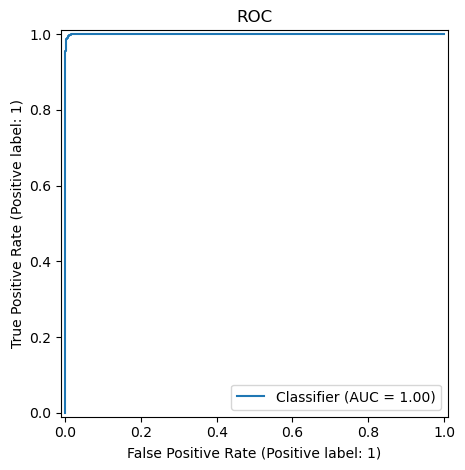

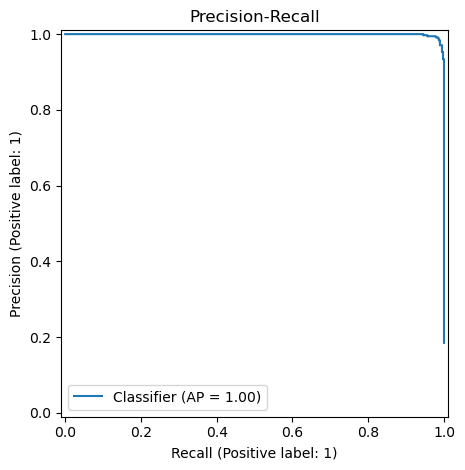

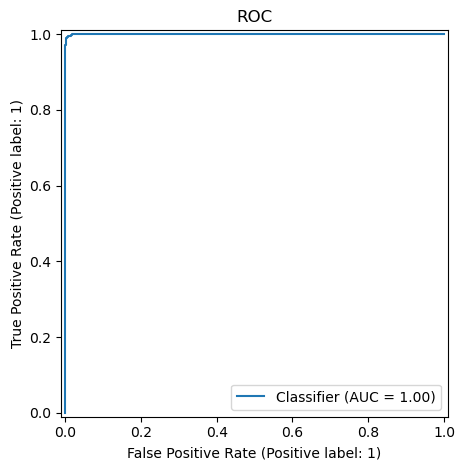

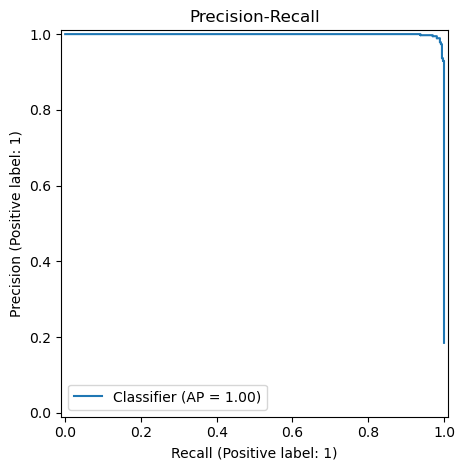

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline

# # Run 1 (baseline)
# rf1 = Pipeline(steps=[
#     ("preproc", preproc),
#     ("clf", RandomForestClassifier(
#         n_estimators=200,
#         max_depth=8,
#         max_features="sqrt",        # explicite la stratégie
#         min_samples_leaf=1,         # par défaut, on rend visible
#         class_weight="balanced",
#         bootstrap=True,             # par défaut, on rend visible
#         random_state=42,
#         n_jobs=-1
#     ))
# ])
# run_with_mlflow(
#     experiment_name="random_forest",                     # 👉 1 modèle = 1 experiment
#     run_name="n200_depth=8_mfsqrt_leaf=1_balanced_seed42",  # 👉 1 itération = 1 run
#     pipeline=rf1,
#     X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
#     params={
#         "model": "random_forest",
#         "n_estimators": 200,
#         "max_depth": 8,
#         "max_features": "sqrt",
#         "min_samples_leaf": 1,
#         "class_weight": "balanced",
#         "bootstrap": True,
#         "random_state": 42
#     }
# )

# # Run 2 (variante améliorée)
# rf2 = Pipeline(steps=[
#     ("preproc", preproc),
#     ("clf", RandomForestClassifier(
#         n_estimators=500,
#         max_depth=10,
#         max_features="sqrt",
#         min_samples_leaf=5,
#         class_weight="balanced_subsample",
#         bootstrap=True,
#         random_state=42,
#         n_jobs=-1
#     ))
# ])
# run_with_mlflow(
#     experiment_name="random_forest",
#     run_name="n500_depth=10_mfsqrt_leaf=5_balancedSub_seed42",
#     pipeline=rf2,
#     X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
#     params={
#         "model": "random_forest",
#         "n_estimators": 500,
#         "max_depth": 10,
#         "max_features": "sqrt",
#         "min_samples_leaf": 5,
#         "class_weight": "balanced_subsample",
#         "bootstrap": True,
#         "random_state": 42
#     }
# )


### 5.5 Expérience : `random_forest` — itérations (runs)

#### 🎯 Objectif
Évaluer la performance d’un modèle **Random Forest** à travers deux configurations distinctes,  
en respectant la logique MLflow :
> *Un modèle = un experiment* et *une configuration = un run.*

#### 🧠 Runs testés
- **Run 1** : `n_estimators=200`, `max_depth=8`, `class_weight=balanced`
- **Run 2** : `n_estimators=500`, `max_depth=10`, `min_samples_leaf=5`, `class_weight=balanced_subsample`

#### 📊 Informations loggées
- **Params** : `n_estimators`, `max_depth`, `max_features`, `min_samples_leaf`, `class_weight`, `bootstrap`, `random_state`
- **Metrics** : `roc_auc`, `pr_auc`, `brier`, `accuracy`
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png`
- **Model** : pipeline complet (prétraitement + estimateur) sauvegardé avec signature et input_example

#### 📈 Résultat attendu dans MLflow
- Experiment : **`random_forest`**
- Deux **runs** visibles dans la table avec leurs hyperparamètres
- Visualisation des **courbes ROC**, **PR**, et de la **matrice de confusion**

#### 🧩 Interprétation
Une Random Forest plus profonde et comportant davantage d’arbres (Run 2)
devrait offrir une **meilleure AUC** mais un **temps d’entraînement plus long**
et un risque accru de **surapprentissage**.


In [ ]:
# --- 5.5 Expérience : random_forest — runs MLflow ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# ==========================================
# 🧩 Expérimentations Random Forest
# ==========================================
# Deux runs MLflow pour évaluer l’impact de la profondeur et du nombre d’arbres :
#   - Run 1 : baseline
#   - Run 2 : configuration enrichie (plus d’arbres, profondeur plus grande)

# -----------------------------
# Run 1 : configuration baseline
# -----------------------------
rf1 = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=200,          # Nombre d’arbres
        max_depth=8,               # Profondeur maximale
        max_features="sqrt",       # Sous-échantillonnage des features
        min_samples_leaf=1,        # Nombre minimal d’échantillons par feuille
        class_weight="balanced",   # Gère le déséquilibre des classes
        bootstrap=True,            # Utilise le bootstrap pour construire les arbres
        random_state=42,
        n_jobs=-1                  # Utilise tous les cœurs CPU disponibles
    ))
])

run_with_mlflow(
    experiment_name="random_forest",                     # 1 modèle = 1 experiment
    run_name="n200_depth=8_mfsqrt_leaf=1_balanced_seed42",  # 1 itération = 1 run
    pipeline=rf1,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    params={
        "model": "random_forest",
        "n_estimators": 200,
        "max_depth": 8,
        "max_features": "sqrt",
        "min_samples_leaf": 1,
        "class_weight": "balanced",
        "bootstrap": True,
        "random_state": 42
    }
)

# -----------------------------
# Run 2 : configuration enrichie
# -----------------------------
rf2 = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=500,             # Plus d’arbres
        max_depth=10,                 # Profondeur plus importante
        max_features="sqrt",
        min_samples_leaf=5,           # Limite le sur-apprentissage
        class_weight="balanced_subsample",
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ))
])

run_with_mlflow(
    experiment_name="random_forest",
    run_name="n500_depth=10_mfsqrt_leaf=5_balSub_seed42",
    pipeline=rf2,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    params={
        "model": "random_forest",
        "n_estimators": 500,
        "max_depth": 10,
        "max_features": "sqrt",
        "min_samples_leaf": 5,
        "class_weight": "balanced_subsample",
        "bootstrap": True,
        "random_state": 42
    }
)


## 6. Sélection automatique du meilleur modèle via MLflow

Une fois toutes les expériences exécutées (Logistic Regression, Decision Tree, Random Forest),
nous exploitons le **tracking MLflow** pour **extraire les meilleurs runs** selon la métrique principale :
**ROC-AUC (test)**.

### Objectif
- Identifier le **meilleur run** de chaque *experiment*.
- Comparer leurs métriques principales (`roc_auc`, `pr_auc`, `brier`, `accuracy`).
- Sélectionner le **meilleur modèle global**.
- Charger automatiquement le modèle sauvegardé dans MLflow.

Cette approche démontre que la sélection du modèle est **pilotée par les résultats réels enregistrés**
et non par un choix manuel.


### 6.1 Extraction des meilleurs runs depuis MLflow

Dans cette étape, nous exploitons le tracking **MLflow** pour identifier automatiquement, pour chaque modèle :
- le **meilleur run** (itération) selon la métrique principale **ROC-AUC**,  
- et les principales métriques associées (**PR-AUC**, **Brier**, **Accuracy**).

Le but est de centraliser les résultats des expériences (régression logistique, arbre de décision et forêt aléatoire)  
dans un tableau synthétique pour comparer objectivement leurs performances.


In [ ]:
# --- 6.1 Chargement du tracking MLflow et extraction des meilleurs runs ---
import mlflow
import pandas as pd

# Liste des expériences à comparer
experiments = ["logistic_regression", "decision_tree", "random_forest"]

best_runs = []

for exp_name in experiments:
    # Récupérer l'ID de l'expérience à partir de son nom
    exp = mlflow.get_experiment_by_name(exp_name)
    if exp is None:
        print(f"⚠️ Expérience non trouvée : {exp_name}")
        continue

    # Récupération de tous les runs de l’expérience
    runs_df = mlflow.search_runs(experiment_ids=[exp.experiment_id])

    # Sélection du meilleur run selon la métrique 'roc_auc'
    best_run = runs_df.sort_values("metrics.roc_auc", ascending=False).iloc[0]
    best_runs.append({
        "experiment": exp_name,
        "run_id": best_run.run_id,
        "roc_auc": best_run["metrics.roc_auc"],
        "pr_auc": best_run["metrics.pr_auc"],
        "brier": best_run["metrics.brier"],
        "accuracy": best_run["metrics.accuracy"]
    })

# Création d’un DataFrame de synthèse
df_best = pd.DataFrame(best_runs).sort_values("roc_auc", ascending=False).reset_index(drop=True)

# Affichage du tableau de comparaison
print("===== 🏁 Meilleurs runs par modèle =====")
display(df_best.style.format({"roc_auc":"{:.3f}", "pr_auc":"{:.3f}", "brier":"{:.3f}", "accuracy":"{:.3%}"}))

# Identification du meilleur modèle global
best_exp_name = df_best.loc[0, "experiment"]
best_run_id = df_best.loc[0, "run_id"]
print(f"\n➡️ Meilleur modèle global : **{best_exp_name}** (run_id={best_run_id})")


### 6.2 Chargement du modèle gagnant depuis MLflow

Une fois le meilleur **run** identifié, nous pouvons recharger automatiquement le **pipeline complet** (prétraitement + modèle)
directement depuis le **tracking MLflow** grâce à son `run_id`.

#### Intérêts :
- Garantir que le modèle utilisé correspond **exactement** à celui enregistré lors de l’expérimentation.  
- Éviter d’avoir à recharger manuellement un fichier `.joblib` local.  
- Préparer la phase de déploiement (API, application Streamlit, etc.).


In [ ]:
# --- 6.2 Chargement du modèle gagnant directement depuis MLflow ---
from mlflow import sklearn as mlflow_sklearn

# Chargement du modèle complet (prétraitement + estimateur)
model_uri = f"runs:/{best_run_id}/model"
best_model = mlflow_sklearn.load_model(model_uri)

print(f"✅ Modèle chargé depuis MLflow : {best_exp_name}")


### 6.3 Vérification du modèle rechargé

Nous vérifions ici que le modèle **rechargé depuis MLflow** fonctionne correctement
et reproduit les mêmes performances que celles observées lors de l’expérimentation.

#### Étapes :
1. Utiliser le modèle rechargé (`best_model`) pour générer les probabilités de défaut sur `X_test`.
2. Recalculer la métrique **ROC-AUC** afin de confirmer que le score est identique
   à celui affiché dans l’interface MLflow.
3. Cette étape garantit la **cohérence et la reproductibilité** entre entraînement et déploiement.


In [ ]:
# --- 6.3 Vérification du modèle sélectionné ---
import numpy as np
from sklearn.metrics import roc_auc_score

# On refait une prédiction sur X_test pour valider le chargement
proba_best = best_model.predict_proba(X_test)[:, 1]
roc = roc_auc_score(y_test, proba_best)

print(f"AUC du modèle rechargé : {roc:.3f}")


### 6.3 Vérification du modèle rechargé

Nous vérifions ici que le modèle **rechargé depuis MLflow** fonctionne correctement
et reproduit les mêmes performances que celles observées lors de l’expérimentation.

#### Étapes :
1. Utiliser le modèle rechargé (`best_model`) pour générer les probabilités de défaut sur `X_test`.
2. Recalculer la métrique **ROC-AUC** afin de confirmer que le score est identique
   à celui affiché dans l’interface MLflow.
3. Cette étape garantit la **cohérence et la reproductibilité** entre entraînement et déploiement.


In [ ]:
# --- 6.4 Sauvegarde locale du modèle rechargé (optionnel) ---

from pathlib import Path
import joblib

# Création du dossier s'il n'existe pas
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Définition du chemin de sauvegarde
model_filename = f"best_model_from_mlflow_{best_exp_name}.joblib"
model_path = ARTIFACTS_DIR / model_filename

# Sauvegarde du modèle rechargé
joblib.dump(best_model, model_path)

print(f"✅ Modèle rechargé sauvegardé localement dans : {model_path}")


#### c est pas la fin ici 

In [45]:
import streamlit as st
import pandas as pd
import joblib, json
from pathlib import Path

# ---- Configuration de la page ----
st.set_page_config(
    page_title="PD – Scoring crédit",
    page_icon="📊",
    layout="centered"
)

# ---- Chargement du modèle et des métriques ----
ART = Path("artifacts")
MODEL_PATH = ART / "logistic_regression_final.joblib"
METRICS_PATH = ART / "best_model_metrics.json"

model = joblib.load(MODEL_PATH)
metrics = json.loads(METRICS_PATH.read_text())

# ---- En-tête de l'application ----
st.title("📊 Évaluation du risque crédit : probabilité de défaut de paiement par client")

st.markdown(
    "Analysez le profil d’un client ou d’un groupe de clients pour estimer leur probabilité de défaut "
    "et faciliter les décisions de crédit."
)

# ---- Affichage des infos du modèle ----
st.markdown("---")
st.subheader("🔍 Modèle utilisé")
st.markdown(
    f"""
    **Nom du modèle :** `{MODEL_PATH.name}`  
    **Performances (jeu de test) :**  
    - **ROC-AUC** : {metrics['roc_auc']:.3f}  
    - **PR-AUC** : {metrics['pr_auc']:.3f}  
    - **Brier score** : {metrics['brier']:.3f}
    """
)

# ---- Auteur (académique) ----
st.markdown("👤 **Auteur :** Jean Dupont — Master Data Science, Université XYZ")

# ---- Saisie unitaire ----
st.markdown("---")
st.subheader("🧮 Prédiction unitaire")

col1, col2 = st.columns(2)

with col1:
    credit_lines_outstanding = st.number_input("📌 Lignes de crédit en cours", min_value=0, step=1, value=1)
    loan_amt_outstanding = st.number_input("💰 Montant du prêt en cours (€)", min_value=0.0, step=100.0, value=3000.0)
    total_debt_outstanding = st.number_input("💳 Dette totale en cours (€)", min_value=0.0, step=100.0, value=8000.0)

with col2:
    income = st.number_input("📈 Revenu annuel (€)", min_value=0.0, step=100.0, value=60000.0)
    years_employed = st.number_input("👔 Ancienneté (années)", min_value=0, step=1, value=5)
    fico_score = st.number_input("🔢 FICO Score", min_value=300, max_value=850, step=1, value=640)

# Seuil décisionnel
theta = st.slider("🎯 Seuil décisionnel (θ)", 0.05, 0.95, 0.50, 0.01)

# Prédiction
if st.button("🔍 Prédire la probabilité de défaut"):
    X = pd.DataFrame([{
        "credit_lines_outstanding": credit_lines_outstanding,
        "loan_amt_outstanding": loan_amt_outstanding,
        "total_debt_outstanding": total_debt_outstanding,
        "income": income,
        "years_employed": years_employed,
        "fico_score": fico_score
    }])
    pd_hat = float(model.predict_proba(X)[:, 1])
    verdict = "❌ Risque Élevé" if pd_hat >= theta else "✅ Fiable"
    
    st.metric("📉 Probabilité de défaut", f"{pd_hat:.2%}")
    st.markdown(f"**Décision (θ = {theta:.2f}) :** {verdict}")

# ---- Traitement par lot (CSV) ----
st.divider()
st.subheader("📂 Prédiction par lot (import CSV)")
st.caption(
    "Le fichier CSV doit contenir les colonnes suivantes : "
    "`credit_lines_outstanding`, `loan_amt_outstanding`, `total_debt_outstanding`, "
    "`income`, `years_employed`, `fico_score`."
)

file = st.file_uploader("📁 Importer un fichier CSV", type=["csv"])
required = ["credit_lines_outstanding", "loan_amt_outstanding", "total_debt_outstanding", 
            "income", "years_employed", "fico_score"]

if file:
    df = pd.read_csv(file)
    missing = [col for col in required if col not in df.columns]
    if missing:
        st.error(f"❗ Colonnes manquantes dans le fichier : {missing}")
    else:
        out = df.copy()
        out["pd"] = model.predict_proba(out[required])[:, 1]
        out["verdict"] = (out["pd"] >= theta).map({True: "Risque Élevé", False: "Fiable"})
        st.success(f"✅ {len(out)} prédiction(s) générée(s)")
        st.dataframe(out.head(20))
        st.download_button(
            "📥 Télécharger les prédictions",
            out.to_csv(index=False).encode("utf-8"),
            "predictions.csv",
            "text/csv"
        )

# ---- Pied de page ----
st.markdown("<hr>", unsafe_allow_html=True)
st.markdown(
    "<p style='text-align: center;'>© 2025 - Projet académique réalisé par Jean Dupont</p>",
    unsafe_allow_html=True
)


2025-10-14 10:58:51.363 
  command:

    streamlit run c:\Users\User\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-14 10:58:51.370 Session state does not function when running a script without `streamlit run`


DeltaGenerator()

### fin de ce que je fais aujourd hui